# Анализ игровых данных Dota 2

## Цель проекта
Cоздание дашборда для игрового блогера.

Задачи:
- загрузка данных
- обработка данных
- подготовка данных для дашборда


In [1]:
!pip install requests pandas

## 1. Загрузка данных по API c https://www.opendota.com/

### 1.1 Импортируем нужные библиотеки

In [42]:

import requests
import pandas as pd
import time
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
url = "https://api.opendota.com/api/explorer"

try:
    # Выполняем GET-запрос
    response = requests.get(url)
    # Проверяем, что запрос успешен (код 200)
    print("Код статуса:", response.status_code)
    # Выводим сырой ответ от сервера
    print("Ответ от API:", response.text[:500]) # Выведем первые 500 символов

except requests.exceptions.RequestException as e:
    print("Произошла ошибка при запросе:", e)

Код статуса: 400
Ответ от API: {"error":"input is not a string"}


### 1.2 Получим идентификаторы последних матчей

In [4]:


def get_match_ids(limit=10):
    """
        Args:
        limit (int): Количество матчей для получения.

    Returns:
        list: Список ID матчей или пустой список в случае ошибки.
    """
    url = "https://api.opendota.com/api/explorer"
    sql_query = f"SELECT match_id FROM matches ORDER BY start_time DESC LIMIT {limit}"

    params = {'sql': sql_query}

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Генерирует исключение для кодов 4xx/5xx

        data = response.json()
        match_ids = [row['match_id'] for row in data['rows']]
        return match_ids

    except requests.exceptions.RequestException as e:
        print(f"Сетевая ошибка: {e}")
        return []
    except ValueError as e:
        print(f"Ошибка парсинга JSON: {e}")
        return []
    except KeyError as e:
        print(f"Ошибка в структуре ответа API: {e}")
        return []

# Использование функции
if __name__ == "__main__":
    latest_matches = get_match_ids(limit=20)
    print("ID последних матчей:", latest_matches)

ID последних матчей: [8551530484, 8551529937, 8551519225, 8551510909, 8551515526, 8551499670, 8551480739, 8551478822, 8551475577, 8551473140, 8551455996, 8551456768, 8551433842, 8551427795, 8551411290, 8551405329, 8551402149, 8551382618, 8551370416, 8551317220]


Получены идентификаторы 10 последних матчей.

### 1.3 Получим детальную информацию о матчах по ID

In [5]:
def get_match_details(match_id):
    """
       
    Args:
        match_id (int): ID матча
    
    Returns:
        dict: Словарь с данными матча или None в случае ошибки
    """
    # Формируем URL запроса
    url = f"https://api.opendota.com/api/matches/{match_id}"
    
    try:
        print(f" Запрашиваем данные матча {match_id}")
        
        # Выполняем GET-запрос
        response = requests.get(url)
        
        # Проверяем статус ответа
        if response.status_code == 200:
            print("Данные успешно получены")
            return response.json()  # Преобразуем JSON в словарь Python
        else:
            print(f"Ошибка! Код статуса: {response.status_code}")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"Сетевая ошибка: {e}")
        return None

# Пример использования
if __name__ == "__main__":
    # Берем реальный ID матча для теста
    test_match_id = 8498256926
    match_data = get_match_details(test_match_id)
    
    if match_data:
        # Посмотрим на структуру данных
        print(f"Ключи в ответе: {list(match_data.keys())[:10]}")  # Первые 10 ключей


 Запрашиваем данные матча 8498256926
Данные успешно получены
Ключи в ответе: ['version', 'match_id', 'draft_timings', 'teamfights', 'objectives', 'chat', 'radiant_gold_adv', 'radiant_xp_adv', 'pauses', 'cosmetics']


### 1.4 Проанализируем структуру полученных данных о матче

In [6]:
def analyze_match_structure(match_data):
    """Анализирует структуру полученных данных о матче"""
    
    print("ОСНОВНАЯ ИНФОРМАЦИЯ О МАТЧЕ:")
    print(f"ID матча: {match_data.get('match_id')}")
    print(f"Длительность: {match_data.get('duration')} секунд")
    print(f"Режим игры: {match_data.get('game_mode')}")
    print(f"Победитель: {'Сияющие' if match_data.get('radiant_win') else 'Тьма'}")
    print(f"Первая кровь: {match_data.get('first_blood_time')} сек")
    
    print(f"ИГРОКИ В МАТЧЕ: {len(match_data.get('players', []))}")
    
    # Посмотрим на первого игрока для примера
    if match_data.get('players'):
        first_player = match_data['players'][0]
        print(f"ПРИМЕР ДАННЫХ ИГРОКА:")
        print(f"ID аккаунта: {first_player.get('account_id')}")
        print(f"ID героя: {first_player.get('hero_id')}")
        print(f"K/D/A: {first_player.get('kills')}/{first_player.get('deaths')}/{first_player.get('assists')}")
        print(f"   GPM/XPM: {first_player.get('gold_per_min')}/{first_player.get('xp_per_min')}")

# Добавляем к нашему примеру
if __name__ == "__main__":
    test_match_id = 8498256926
    match_data = get_match_details(test_match_id)
    
    if match_data:
        analyze_match_structure(match_data)


 Запрашиваем данные матча 8498256926
Данные успешно получены
ОСНОВНАЯ ИНФОРМАЦИЯ О МАТЧЕ:
ID матча: 8498256926
Длительность: 1637 секунд
Режим игры: 2
Победитель: Сияющие
Первая кровь: 329 сек
ИГРОКИ В МАТЧЕ: 10
ПРИМЕР ДАННЫХ ИГРОКА:
ID аккаунта: 1068676453
ID героя: 11
K/D/A: 8/5/11
   GPM/XPM: 718/810


### 1.5 Получим данные о нескольких матчах


In [7]:
def get_multiple_matches(match_ids, delay=1.0):
    """
    Получает данные о нескольких матчах
    
    Args:
        match_ids (list): Список ID матчей
        delay (float): Задержка между запросами в секундах
    
    Returns:
        dict: Словарь {match_id: match_data}
    """
    matches_data = {}
    
    for i, match_id in enumerate(match_ids):
        print(f"Прогресс: {i+1}/{len(match_ids)}")
        
        # Получаем данные матча
        match_data = get_match_details(match_id)
        
        if match_data:
            matches_data[match_id] = match_data
        
        # Делаем задержку между запросами
        if i < len(match_ids) - 1:  # Не ждем после последнего запроса
            print(f"Ожидание {delay} секунд")
            time.sleep(delay)
    
    return matches_data

# Пример использования с нашими ID матчей
if __name__ == "__main__":
    # Предположим, у нас есть список ID матчей
    match_ids = [8498256926, 8498233827, 8498201404, 8498154923]
    print("Начинаем сбор данных о матчах...")
    all_matches = get_multiple_matches(match_ids, delay=1.0)
    print(f"Сбор завершен! Обработано матчей: {len(all_matches)}")


Начинаем сбор данных о матчах...
Прогресс: 1/4
 Запрашиваем данные матча 8498256926
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 2/4
 Запрашиваем данные матча 8498233827
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 3/4
 Запрашиваем данные матча 8498201404
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 4/4
 Запрашиваем данные матча 8498154923
Данные успешно получены
Сбор завершен! Обработано матчей: 4


### 1.6 Сохраняем данные о матчах в json формате

In [8]:
def save_matches_to_file(matches_data, filename="matches_data.json"):
    """
    Сохраняет данные матчей в JSON файл
    
    Args:
        matches_data (dict): Данные матчей
        filename (str): Имя файла для сохранения
    """
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(matches_data, f, indent=2, ensure_ascii=False)
        
        print(f"Данные сохранены в файл: {filename}")
        print(f"Размер файла: {os.path.getsize(filename)} байт")
        
    except Exception as e:
        print(f"Ошибка при сохранении файла: {e}")

def load_matches_from_file(filename="matches_data.json"):
    """
    Загружает данные матчей из JSON файла
    
    Args:
        filename (str): Имя файла
    
    Returns:
        dict: Данные матчей
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        print(f"Данные загружены из файла: {filename}")
        return data
        
    except FileNotFoundError:
        print(f"Файл {filename} не найден")
        return {}
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return {}


if __name__ == "__main__":
    match_ids = [8498256926, 8498233827, 8498201404, 8498154923]

    
    all_matches = get_multiple_matches(match_ids, delay=1.0)
    
    if all_matches:
        save_matches_to_file(all_matches)
        
        # Проверяем загрузку
        loaded_matches = load_matches_from_file()
        print(f"Загружено матчей: {len(loaded_matches)}")




Прогресс: 1/4
 Запрашиваем данные матча 8498256926
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 2/4
 Запрашиваем данные матча 8498233827
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 3/4
 Запрашиваем данные матча 8498201404
Данные успешно получены
Ожидание 1.0 секунд
Прогресс: 4/4
 Запрашиваем данные матча 8498154923
Данные успешно получены
Данные сохранены в файл: matches_data.json
Размер файла: 1996998 байт
Данные загружены из файла: matches_data.json
Загружено матчей: 4


In [9]:
#загрузим данные о матчах из заранее подготовленных json файлов
files = glob.glob(r"C:\Users\workp\code\DOTA\dota_matches\matches\*.json")
all_matches = [json.load(open(f)) for f in files]
print(len(all_matches))

19912


Все данные о матчах загружены, у нас есть информация о 19912 сатчах для анализа.

### 1.7 Получаем и сохраняем информацию о героях в json


In [10]:
#запросим информацию о героях
url = "https://api.opendota.com/api/heroes"
try:
    response = requests.get(url)
    print("Код статуса:",response.status_code)
    
    heroes_info = response.json()
    print("Всего строк:",len(heroes_info))
    print(heroes_info[0])
except requests.exceptions.RequestException as e:
    print("Произошла ошибка при запросе:", e)   
except ValueError as e:
        print(f"Ошибка парсинга JSON: {e}")
except KeyError as e:
        print(f"Ошибка в структуре ответа API: {e}")
   

Код статуса: 200
Всего строк: 126
{'id': 1, 'name': 'npc_dota_hero_antimage', 'localized_name': 'Anti-Mage', 'primary_attr': 'agi', 'attack_type': 'Melee', 'roles': ['Carry', 'Escape', 'Nuker'], 'legs': 2}


In [11]:
#запросим информацию о статистике героев
url = "https://api.opendota.com/api/heroStats"
response = requests.get(url)

print(response.status_code)

200


In [12]:
heroes_stats_info = response.json()
print(len(heroes_stats_info))
print(heroes_stats_info[0])

126
{'id': 1, 'name': 'npc_dota_hero_antimage', 'primary_attr': 'agi', 'attack_type': 'Melee', 'roles': ['Carry', 'Escape', 'Nuker'], 'img': '/apps/dota2/images/dota_react/heroes/antimage.png?', 'icon': '/apps/dota2/images/dota_react/heroes/icons/antimage.png?', 'base_health': 120, 'base_health_regen': 1, 'base_mana': 75, 'base_mana_regen': 0, 'base_armor': 1, 'base_mr': 25, 'base_attack_min': 29, 'base_attack_max': 33, 'base_str': 21, 'base_agi': 24, 'base_int': 12, 'str_gain': 1.6, 'agi_gain': 2.8, 'int_gain': 1.8, 'attack_range': 150, 'projectile_speed': 0, 'attack_rate': 1.4, 'base_attack_time': 100, 'attack_point': 0.3, 'move_speed': 310, 'turn_rate': None, 'cm_enabled': True, 'legs': 2, 'day_vision': 1800, 'night_vision': 800, 'localized_name': 'Anti-Mage', '1_pick': 45241, '1_win': 23700, '2_pick': 95557, '2_win': 49928, '3_pick': 109222, '3_win': 56581, '4_pick': 97219, '4_win': 49964, '5_pick': 70359, '5_win': 35903, '6_pick': 43356, '6_win': 21787, '7_pick': 39355, '7_win': 1

### 1.8 Получаем и сохраняем информацию о предметах в json, создаем датасет df_items

In [13]:
url = "https://api.opendota.com/api/constants/items"
items = requests.get(url).json()

df_items = pd.DataFrame(items).T   
df_items.reset_index(drop=True, inplace=True)

df_items.head()

,abilities,hint,id,img,dname,qual,cost,behavior,notes,attrib,...,components,created,charges,dmg_type,target_team,target_type,dispellable,bkbpierce,tier,desc
0,"[{'type': 'active', 'title': 'Blink', 'descrip...",[],1,/apps/dota2/images/dota_react/items/blink.png?...,Blink Dagger,component,2250,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,None,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'type': 'active', 'title': 'Overwhelming Bli...",[],600,/apps/dota2/images/dota_react/items/overwhelmi...,Overwhelming Blink,component,6800,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,"[blink, reaver]",True,False,Magical,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'type': 'active', 'title': 'Swift Blink', 'd...",[],603,/apps/dota2/images/dota_react/items/swift_blin...,Swift Blink,component,6800,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,"[blink, eagle]",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'type': 'active', 'title': 'Arcane Blink', '...",[],604,/apps/dota2/images/dota_react/items/arcane_bli...,Arcane Blink,component,6800,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1400'}, {'ke...",...,"[blink, mystic_staff]",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,606,/apps/dota2/images/dota_react/items/recipe.png...,Arcane Blink Recipe,NaN,1750,False,,[],...,None,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Загружаем предметы
with open(r"C:\Users\workp\code\DOTA\items.json", encoding='utf-8') as f:
    items = json.load(f)
print(f"Загружено предметов: {len(items)}")

Загружено предметов: 510


Словарь предметов загружен, в нем 510 предметов.

## 2 Сохранение данных в csv (для построения дашборда в Tableau)

### 2.1 Создаем датасет match_info и matches.csv с информацией о матчах

Зададим функцию для извлечения нужной нам информации о матче из json.

In [15]:
def extract_match_info(match_data):
    """
    Извлекает основную информацию о матче.

    Args:
        match_data (dict): Словарь с данными матча.

    Returns:
        dict: Словарь с основной информацией о матче.
    """
    # Всегда используем .get() для безопасного доступа к ключам!
    match_info = {
        'match_id': match_data.get('match_id'),
        'duration_sec': match_data.get('duration'),
        'duration_min': round(match_data.get('duration', 0) / 60, 1),  # Переводим секунды в минуты
        'radiant_win': match_data.get('radiant_win'),
        'game_mode': match_data.get('game_mode'),
        'start_time': match_data.get('start_time'),
        'league_name': match_data.get('league_name', 'Неизвестно'),# Если лиги нет, подставляем "Неизвестно"
        'first_blood_time': match_data.get ('first_blood_time'),
        'region':match_data.get ('region')
    }
    return match_info

In [16]:
#применим функцию в цикле для всех матчей
matches_data = []

for match in all_matches:
    match_info = extract_match_info(match)
    matches_data.append(match_info)

print(f"Всего матчей: {len(matches_data)}")

Всего матчей: 19912


In [17]:

df_matches = pd.DataFrame(matches_data)
df_matches.to_csv(r"C:\Users\workp\code\DOTA\CSV\matches.csv", index=False, encoding='utf-8-sig')

print("Файл matches.csv сохранён")

Файл matches.csv сохранён


Данные всех матчей сохранены в 1 csv файл.

### 2.2 Создадим датасет df_players и players.csv c информацией об игроках.

Создадим функцию, которая извлекает данные об игроках.

In [18]:
def extract_players_data(match_data):
    """
    Извлекает данные обо всех игроках в матче.

    Args:
        match_data (dict): Словарь с данными матча.

    Returns:
        list: Список словарей с данными каждого игрока.
    """
    players_info = []
    players_list = match_data.get('players', [])

    print(f"Обрабатываем данные {len(players_list)} игроков")

    duration = match_data.get('duration', 1)  # чтобы можно было посчитать "в минуту"

    for player in players_list:
        # безопасное извлечение метрик
        hero_damage = player.get('hero_damage', 0)
        hero_healing = player.get('hero_healing', 0)
        tower_damage = player.get('tower_damage', 0)
        last_hits = player.get('last_hits', 0)

        # расчёт метрик "в минуту"
        last_hits_per_min = round(last_hits / (duration / 60), 2)
        hero_damage_per_min = round(hero_damage / (duration / 60), 2)
        hero_healing_per_min = round(hero_healing / (duration / 60), 2)
        tower_damage_per_min = round(tower_damage / (duration / 60), 2)

        player_info = {
            'match_id': match_data.get('match_id'),
            'account_id': player.get('account_id'),
            'player_slot': player.get('player_slot'),
            'isRadiant': player.get('isRadiant'),
            'win': player.get('win'),
            

            # герой и статистика
            'hero_id': player.get('hero_id'),
            'level': player.get('level', 0),
            'kills': player.get('kills', 0),
            'deaths': player.get('deaths', 0),
            'assists': player.get('assists', 0),
            'gold_per_min': player.get('gold_per_min', 0),
            'xp_per_min': player.get('xp_per_min', 0),
            'net_worth': player.get('net_worth', 0),

            # нанесённый урон и фарм
            'hero_damage': hero_damage,
            'hero_healing': hero_healing,
            'tower_damage': tower_damage,
            'last_hits': last_hits,

            # производные метрики
            'last_hits_per_min': last_hits_per_min,
            'hero_damage_per_min': hero_damage_per_min,
            'hero_healing_per_min': hero_healing_per_min,
            'tower_damage_per_min': tower_damage_per_min,

            # предметы
            'item_0': player.get('item_0'),
            'item_1': player.get('item_1'),
            'item_2': player.get('item_2'),
            'item_3': player.get('item_3'),
            'item_4': player.get('item_4'),
            'item_5': player.get('item_5'),
            'backpack_0': player.get('backpack_0'),
            'backpack_1': player.get('backpack_1'),
            'backpack_2': player.get('backpack_2'),
            'item_neutral': player.get('item_neutral')
        }

        players_info.append(player_info)

    return players_info


In [19]:
all_players_data = []

for match in all_matches:
    # получаем список игроков из одного матча
    players = extract_players_data(match)
    # добавляем их в общий список
    all_players_data.extend(players)  # extend, не append!

print(f"Всего игроков: {len(all_players_data)}")

# сохраняем в csv

df_players = pd.DataFrame(all_players_data)
df_players.to_csv(r"C:\Users\workp\code\DOTA\CSV\players.csv", index=False, encoding='utf-8-sig')
print("Файл players.csv сохранён")

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Данные всех игроков обработаны и загружены в датасет df_players, посмотрим его первые строки.

In [20]:
df_players.head()

,match_id,account_id,player_slot,isRadiant,win,hero_id,level,kills,deaths,assists,...,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,item_neutral
0,8127690162,349310876,0,True,0,31,13,2,12,9,...,214,43,0,593,36,12,1127,0,0,298
1,8127690162,1031547092,1,True,0,65,15,3,7,8,...,1,37,102,218,36,29,0,0,0,574
2,8127690162,352545711,2,True,0,129,18,3,6,10,...,41,1,50,116,178,34,0,0,0,950
3,8127690162,164685175,3,True,0,49,22,3,4,1,...,151,154,63,116,26,135,5,0,0,950
4,8127690162,308163407,4,True,0,60,15,5,6,6,...,50,36,16,1107,73,116,0,0,0,950


### 2.3 Создадим датасет items_df и items_dict.csv  с информацией о предметах

In [21]:
items_list = []

for key, val in items.items():
    val["item_name"] = key  # сохраняем название предмета
    items_list.append(val)

# создаём DataFrame
df_items = pd.DataFrame(items_list)

In [32]:
df_items.head()

,abilities,hint,id,img,dname,qual,cost,behavior,notes,attrib,...,created,charges,item_name,dmg_type,target_team,target_type,dispellable,bkbpierce,tier,desc
0,"[{'type': 'active', 'title': 'Blink', 'descrip...",[],1,/apps/dota2/images/dota_react/items/blink.png?...,Blink Dagger,component,2250.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,False,False,blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'type': 'active', 'title': 'Overwhelming Bli...",[],600,/apps/dota2/images/dota_react/items/overwhelmi...,Overwhelming Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,True,False,overwhelming_blink,Magical,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'type': 'active', 'title': 'Swift Blink', 'd...",[],603,/apps/dota2/images/dota_react/items/swift_blin...,Swift Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,True,False,swift_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'type': 'active', 'title': 'Arcane Blink', '...",[],604,/apps/dota2/images/dota_react/items/arcane_bli...,Arcane Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1400'}, {'ke...",...,True,False,arcane_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,606,/apps/dota2/images/dota_react/items/recipe.png...,Arcane Blink Recipe,NaN,1750.0,False,,[],...,False,False,recipe_arcane_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
output_path = r"C:\Users\workp\code\DOTA\CSV\items_dict.csv"
df_items.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"Предметы сохранены в {output_path}")

Предметы сохранены в C:\Users\workp\code\DOTA\CSV\items_dict.csv


### 2.4 Создадим датасет heroes_merged и heroes.csv  с информацией о героях и предметах

Объявим функцию, которая создаёт heroes.csv и items_dict.csv из уже загруженных данных

In [25]:
def save_hero_and_item_dicts(heroes_info, heroes_stats_info, items, output_dir):
    

    # --- ГЕРОИ ---
    heroes_df = pd.DataFrame(heroes_info)
    heroes_stats_df = pd.DataFrame(heroes_stats_info)

    heroes_merged = heroes_df.merge(
        heroes_stats_df[["id", "primary_attr", "attack_type", "legs", "roles"]],
        on="id",
        how="left"
    )

    heroes_merged.columns = heroes_merged.columns.str.strip()
    heroes_merged.to_csv(f"{output_dir}/heroes.csv", index=False, sep=",", encoding="utf-8-sig")

    # --- ПРЕДМЕТЫ ---
    items_list = []
    for key, val in items.items():
        val["item_name"] = key
        items_list.append(val)

    items_df = pd.DataFrame(items_list)
    items_df.columns = items_df.columns.str.strip()
    items_df.to_csv(f"{output_dir}/items_dict.csv", index=False, sep=",", encoding="utf-8-sig")

    print("CSV со справочниками успешно созданы!")
    return heroes_merged, items_df


In [27]:

OUTPUT_DIR = r"C:\Users\workp\code\DOTA\CSV"


save_hero_and_item_dicts(heroes_info, heroes_stats_info, items, OUTPUT_DIR)

print("\n Готово! Все 5 таблиц сохранены в:", OUTPUT_DIR)


CSV со справочниками успешно созданы!

 Готово! Все 5 таблиц сохранены в: C:\Users\workp\code\DOTA\CSV


In [28]:
heroes_merged, items_df = save_hero_and_item_dicts(heroes_info, heroes_stats_info, items, OUTPUT_DIR)
heroes_merged.head()

CSV со справочниками успешно созданы!


,id,name,localized_name,primary_attr_x,attack_type_x,roles_x,legs_x,primary_attr_y,attack_type_y,legs_y,roles_y
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"[Carry, Escape, Nuker]",2,agi,Melee,2,"[Carry, Escape, Nuker]"
1,2,npc_dota_hero_axe,Axe,str,Melee,"[Initiator, Durable, Disabler, Carry]",2,str,Melee,2,"[Initiator, Durable, Disabler, Carry]"
2,3,npc_dota_hero_bane,Bane,all,Ranged,"[Support, Disabler, Nuker, Durable]",4,all,Ranged,4,"[Support, Disabler, Nuker, Durable]"
3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"[Carry, Disabler, Nuker, Initiator]",2,agi,Melee,2,"[Carry, Disabler, Nuker, Initiator]"
4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"[Support, Disabler, Nuker]",2,int,Ranged,2,"[Support, Disabler, Nuker]"


### 2.5 Добавим словарь имен игроков (для дашборда)


Загрузим нужные данные - имя и ID по API

In [29]:
def extract_players_name(match_data):
    players_name = []
    players_list = match_data.get('players', [])

    print(f"Обрабатываем данные {len(players_list)} игроков")

    for player in players_list:
        players_name.append({
            'account_id': player.get('account_id'),
            'name': player.get('personaname') or player.get('name') or 'Unknown'
        })

    return players_name


Добавим все данные в 1 список и сохраним в csv

In [30]:
all_players_name = []

for match in all_matches:
    # получаем список игроков из одного матча
    players = extract_players_name(match)
    # добавляем их в общий список
    all_players_name.extend(players)  # extend, не append!

print(f"Всего игроков: {len(all_players_name)}")

# сохраняем в CSV

df_players_name = pd.DataFrame(all_players_name)
df_players_name.to_csv(r"C:\Users\workp\code\DOTA\CSV\players_name.csv", index=False, encoding='utf-8-sig')
print("Файл players_name.csv сохранён")

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабатываем данные 10 игроков
Обрабаты

Файл players_name.csv сохранён


In [31]:
df_players_name.head()

,account_id,name
0,349310876,impermanencia
1,1031547092,R...K..R
2,352545711,Seishiro Nagi
3,164685175,relax boy
4,308163407,Desenfocao'


## Итог
**В результате первой части работы:**
1. Загружены данные по API с https://www.opendota.com/ в виде json-файлов.
2. Из json-файлов созданы датасеты для дальнейшего анализа на python и csv-файлы для закрузки в Tableau и постороения дашбордов. 

# Анализ игровых данных Dota 2

Для анализа будем использовать ранее полученные 4 датасета:
- df_matches Матчи
- df_players Игроки
- heroes_merged
- df_items

<div style="background-color:#e6ffe6; border-left: 6px solid #4CAF50; padding:10px;">
<b>План анализа:</b> 


1. Проверить есть ли корреляция между числовыми параметрами и победой в матче;
2. Построить гистограммы основных параметров матчей (убийства, ассисты, урон в минуту и прочие) в разрезе победивших и проигравших команд и сделать выводы;
3. Какие предметы чаще приводят команду к победе: топ используемых в матчах предметов, в разрезе победителей / проигравших, какие предметы есть у победителей, которых нет у проигравших;
4. Какой герой фармит больше всего золота: по всем матчам, есть ли разница в количестве золота нафармленного героем в разрезе победа / поражение;
5. Какие герои получают больше всего опыта за игру;
6. Какие фракции чаще побеждают: свет или тьма;
7. Каких героев чаще всего выбирают;
8. Какие герои чаще всего выигрывают;
9. Какие герои совершают больше всего убийств, ассистов;
10. Какой герой меньше всего умирает;
11. Сколько в среднем длится матч;
12. Среднее время до первой крови + гистограмма;
13. Найдите 10 топовых игроков по проценту побед: отличаются ли статы в их матчах от матчей, где их нет;
14. Влияет ли средний процент побед игроков в команде на победу команды;
15. Какие герои могут повлиять на исход матча (наличие carry в столбце роль) в долгих играх (больше 50 минут);

</div>

## 1 EDA 

### 1.1 Оценка целостности данных

In [33]:
# Смотрим на форму и колонки
print("Matches:", df_matches.shape)
print(df_matches.columns)
print("Players:", df_players.shape)
print(df_players.columns)
print("Items:", df_items.shape)
print(df_items.columns)
print("Heroes", heroes_merged.shape)
print(heroes_merged.columns)

# Типы данных
print(df_players.dtypes)
print(df_matches.dtypes)
print(df_items.dtypes)
print(heroes_merged.shape)

# Пропуски
print(df_players.isna().sum().sort_values(ascending=False).head(10))
print(df_matches.isna().sum().sort_values(ascending=False).head(10))
print(df_items.isna().sum().sort_values(ascending=False).head(10))
print(heroes_merged.isna().sum().sort_values(ascending=False).head(10))

Matches: (19912, 9)
Index(['match_id', 'duration_sec', 'duration_min', 'radiant_win', 'game_mode',
       'start_time', 'league_name', 'first_blood_time', 'region'],
      dtype='object')
Players: (199120, 31)
Index(['match_id', 'account_id', 'player_slot', 'isRadiant', 'win', 'hero_id',
       'level', 'kills', 'deaths', 'assists', 'gold_per_min', 'xp_per_min',
       'net_worth', 'hero_damage', 'hero_healing', 'tower_damage', 'last_hits',
       'last_hits_per_min', 'hero_damage_per_min', 'hero_healing_per_min',
       'tower_damage_per_min', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'backpack_0', 'backpack_1', 'backpack_2',
       'item_neutral'],
      dtype='object')
Items: (510, 25)
Index(['abilities', 'hint', 'id', 'img', 'dname', 'qual', 'cost', 'behavior',
       'notes', 'attrib', 'mc', 'hc', 'cd', 'lore', 'components', 'created',
       'charges', 'item_name', 'dmg_type', 'target_team', 'target_type',
       'dispellable', 'bkbpierce', 'tier', 'desc'

**📝ВЫВОД**: 

* Все основные таблицы имеют общий первичный ключ match_id, в котором нет пропусков. Это гарантирует корректное объединение таблиц Matches и Players.

* Соотношение количества строк соответствует игровой логике: ~19 912 матчей и 199 120 записей игроков (≈10 игроков на матч), что подтверждает соответствие структуре данных Dota 2.

* В ключевых игровых метриках (kills, deaths, assists, GPM, XPM и др.) отсутствуют пропуски — это позволяет рассчитывать derived-метрики (KDA, win rate, performance) без дополнительных заполнений.

* Пропуски присутствуют только в описательных атрибутах (в основном в Items), что не влияет на точность анализа и не нарушает модель данных.

* Справочник героев заполнен полностью, что обеспечивает корректное сопоставление измерений.

**ИТОГ:**
Данные можно считать целостными и готовыми для аналитического использования.

### 1.2 Анализ распределений числовых признаков

In [34]:
#Основные статистики по числовым колонкам
num_cols = ['kills', 'deaths', 'assists', 'gold_per_min', 'xp_per_min', 
            'last_hits', 'hero_damage', 'hero_healing', 'tower_damage', 'net_worth']
print(df_players[num_cols].describe().T)



                 count          mean           std    min      25%      50%  \
kills         199120.0      5.885607      4.608777    0.0      2.0      5.0   
deaths        199120.0      6.002822      3.529582    0.0      3.0      6.0   
assists       199120.0     11.978912      7.293617    0.0      6.0     11.0   
gold_per_min  199120.0    485.033357    167.651254   90.0    350.0    472.0   
xp_per_min    199120.0    631.987550    225.165981    5.0    466.0    608.0   
last_hits     199120.0    178.964896    142.195687    0.0     58.0    158.0   
hero_damage   199120.0  18870.495982  12050.939902  150.0  10558.0  15940.0   
hero_healing  199120.0    816.348483   2757.961541    0.0      0.0      0.0   
tower_damage  199120.0   2360.149879   4130.923651    0.0     97.0    659.0   
net_worth     199120.0  14948.619029   7498.476729    0.0   9436.0  13674.0   

                  75%       max  
kills             8.0      44.0  
deaths            8.0      28.0  
assists          17.0      5

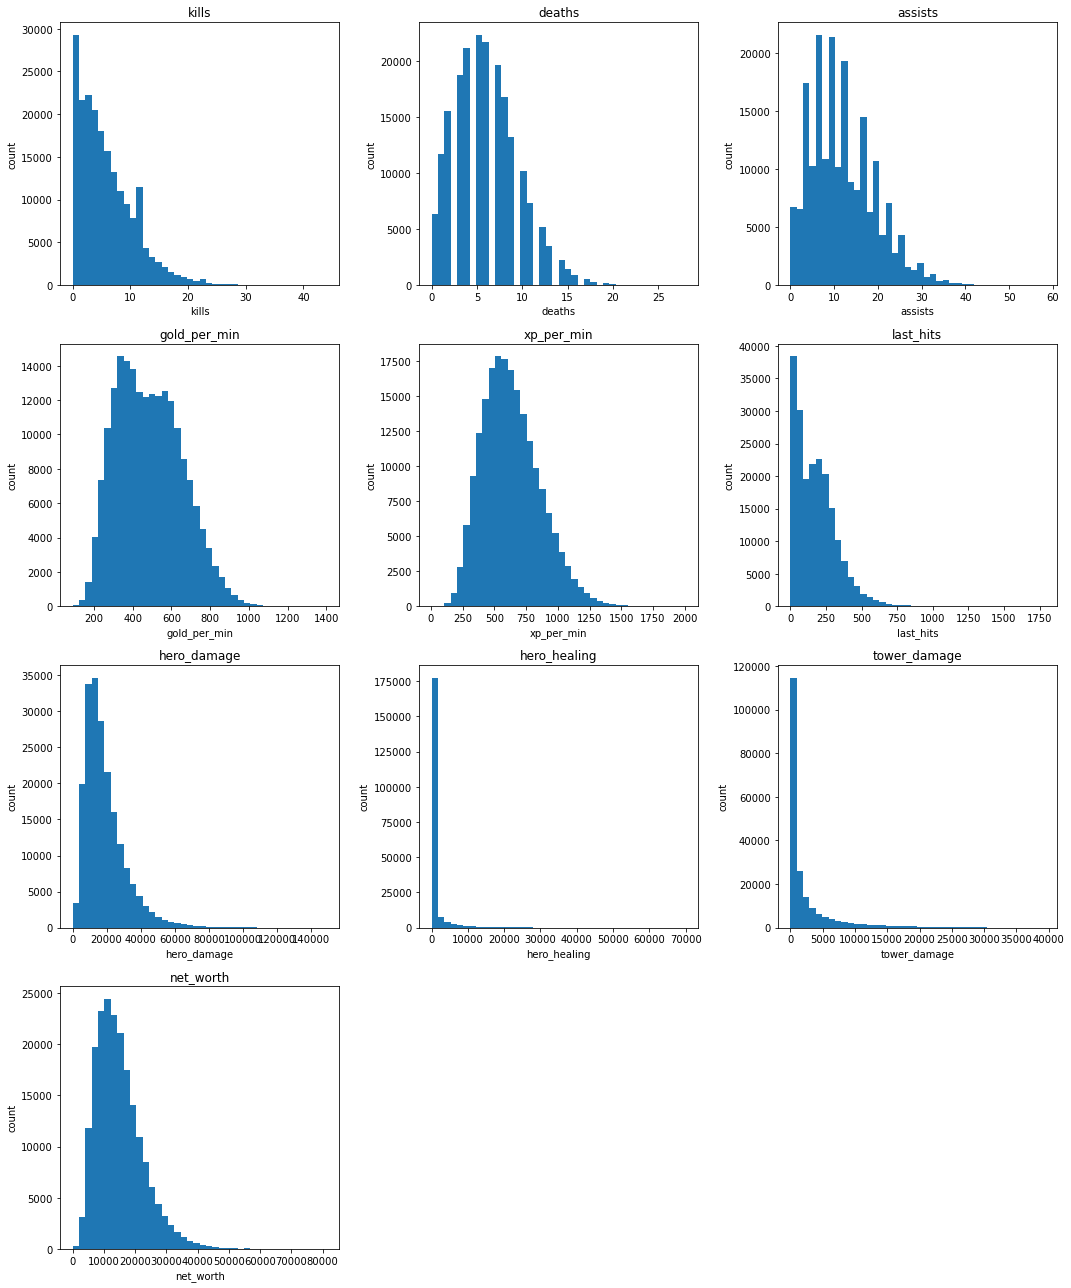

In [37]:
num_cols = ['kills', 'deaths', 'assists', 'gold_per_min', 'xp_per_min', 
            'last_hits', 'hero_damage', 'hero_healing', 'tower_damage', 'net_worth']

plt.figure(figsize=(15, 18))

for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    plt.hist(df_players[col], bins=40)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")

plt.tight_layout()
plt.show()

**📝ВЫВОД**: Аномальных значений и выбросов нет

### 1.3 Проверим есть ли корреляция между числовыми параметрами и победой в матче

**Агрегируем данные по командам**

In [38]:
df_players['team'] = df_players['player_slot'].apply(lambda x: 'Radiant' if x < 128 else 'Dire')


In [39]:
metrics = [
    'kills', 'deaths', 'assists', 
    'gold_per_min', 'xp_per_min', 
    'last_hits', 'hero_damage_per_min', 
    'hero_healing_per_min', 'tower_damage_per_min',
    'net_worth'
]

# Агрегируем: суммируем kills, deaths, assists, net_worth, а для средних — GPM, XPM и dmg
agg_dict = {
    'kills': 'sum',
    'deaths': 'sum',
    'assists': 'sum',
    'gold_per_min': 'mean',
    'xp_per_min': 'mean',
    'last_hits': 'sum',
    'hero_damage_per_min': 'mean',
    'hero_healing_per_min': 'mean',
    'tower_damage_per_min': 'mean',
    'net_worth': 'sum',
    'win': 'max'  # если кто-то из команды выиграл, вся команда выиграла
}

df_team = df_players.groupby(['match_id', 'team']).agg(agg_dict).reset_index()
df_team.head()

,match_id,team,kills,deaths,assists,gold_per_min,xp_per_min,last_hits,hero_damage_per_min,hero_healing_per_min,tower_damage_per_min,net_worth,win
0,8127690162,Dire,33,16,80,524.2,588.2,808,692.970,19.532,193.692,83122,1
1,8127690162,Radiant,16,35,34,402.8,502.2,893,417.184,1.738,6.056,58223,0
2,8127691029,Dire,27,9,76,508.0,596.6,876,496.550,16.740,121.684,78052,1
3,8127691029,Radiant,9,28,19,342.0,395.6,711,337.730,41.216,14.298,50252,0
4,8127718999,Dire,25,38,48,489.6,641.0,815,695.056,0.776,70.508,70017,0


In [40]:
# выберем числовые поля
numeric_cols = df_players.select_dtypes(include='number').columns
print(numeric_cols)

Index(['match_id', 'account_id', 'player_slot', 'win', 'hero_id', 'level',
       'kills', 'deaths', 'assists', 'gold_per_min', 'xp_per_min', 'net_worth',
       'hero_damage', 'hero_healing', 'tower_damage', 'last_hits',
       'last_hits_per_min', 'hero_damage_per_min', 'hero_healing_per_min',
       'tower_damage_per_min', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'backpack_0', 'backpack_1', 'backpack_2',
       'item_neutral'],
      dtype='object')


In [45]:
#посчитаем корреляцию с победой 
corr_with_win = df_players[numeric_cols].corr()['win'].sort_values(ascending=False).round(2)
print(corr_with_win)

win                     1.00
assists                 0.50
xp_per_min              0.40
tower_damage_per_min    0.40
tower_damage            0.37
gold_per_min            0.36
kills                   0.34
net_worth               0.30
level                   0.28
hero_damage_per_min     0.22
hero_damage             0.16
hero_healing_per_min    0.11
hero_healing            0.09
last_hits_per_min       0.07
last_hits               0.05
item_1                  0.02
item_2                  0.01
item_0                  0.01
item_3                  0.01
item_neutral            0.01
item_4                  0.01
item_5                  0.01
hero_id                 0.00
backpack_2              0.00
match_id                0.00
account_id             -0.01
backpack_1             -0.01
backpack_0             -0.02
player_slot            -0.05
deaths                 -0.44
Name: win, dtype: float64


**📝ВЫВОД**:

* Самая большая прямая корреляция между win и полями:
assists количество ассистов в матче                
xp_per_min количества опыта за минуту в матче              
tower_damage_per_min количество урона башен в минуту матча

* Средняя:
tower_damage Урон башен            
gold_per_min  Количество золота, которое игрок получает за минуту в матче         
kills Количество убийств в матче                  

* Невысокая, но заметная:
net_worth Суммарная ценность героя на момент окончания матча              
level  Уровень героя в конце матча                 
hero_damage_per_min Средний урон по героям противника в минуту

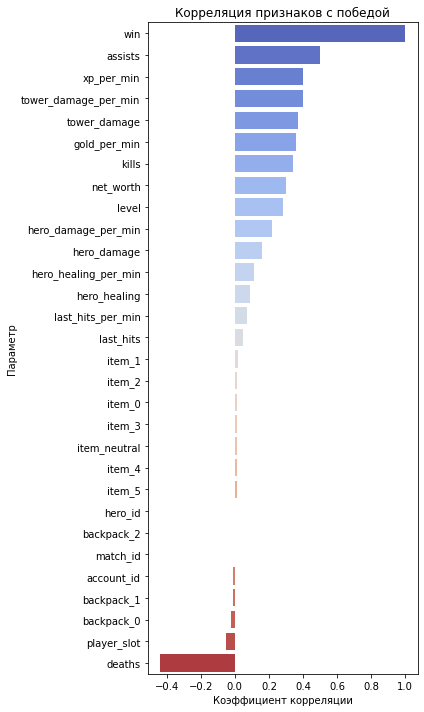

In [46]:
plt.figure(figsize=(6, 10))
sns.barplot(x=corr_with_win.values, y=corr_with_win.index, palette='coolwarm')
plt.title('Корреляция признаков с победой')
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Параметр')
plt.tight_layout()
plt.show()

**📝ВЫВОД**:
Высокое влияние на победу оказывает:
* количество ассистов
* количество опыта в минуту
* нанесенный урон
* заработанное золото
* количество убийств

  Это логично, потому что это и ведет к победе
  Высокие net_worth (экономический показатель) и level (уровень игрока) тоже увеличивают вероятность победы.
  Посмотрим, возможно есть какие корреляции между другими данными.

Построим корреляционную матрицу для числовых полей

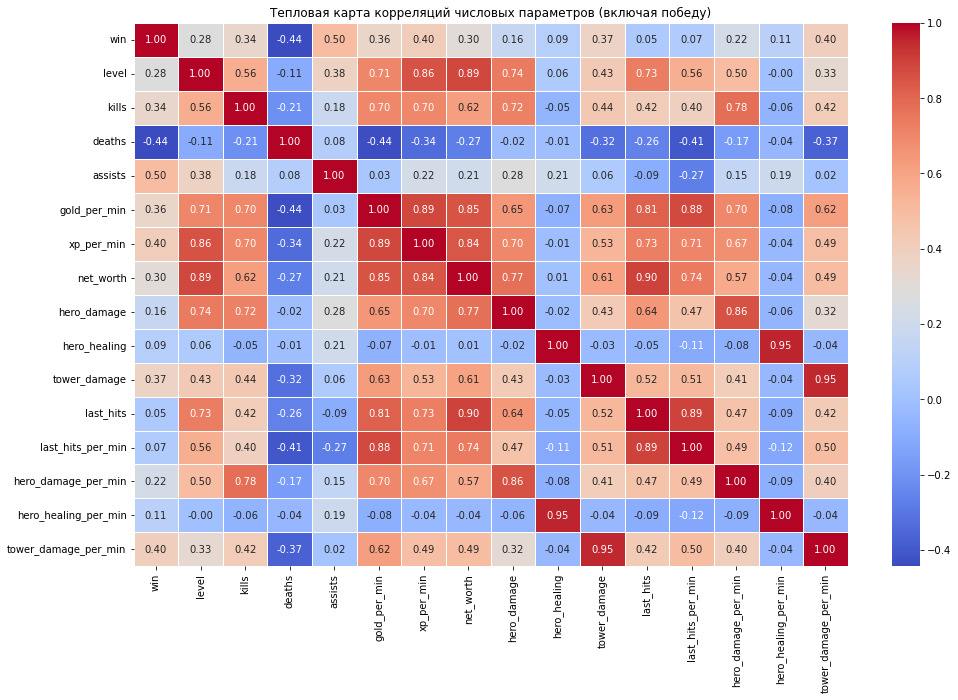

In [48]:
# Выбираем только числовые столбцы



cols_to_exclude = [
    'match_id', 'account_id', 'player_slot', 'hero_id',
    'item_0','item_1','item_2','item_3','item_4','item_5',
    'backpack_0','backpack_1','backpack_2','item_neutral'
]

numeric_df = df_players.select_dtypes(include=['int64', 'float64']).drop(columns=cols_to_exclude)
corr = numeric_df.corr()

# Отрисовываем тепловую карту
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Тепловая карта корреляций числовых параметров (включая победу)")
plt.show()

**📝ВЫВОД**:
Заметно, что:
* уровень героя влияет на количество последних ударов, убийств, экономический статус и количество опыта в минуту


### 1.4 Построим гистограммы основных параметров матчей (убийства, ассисты, урон в минуту и прочие) в разрезе победивших и проигравших команд

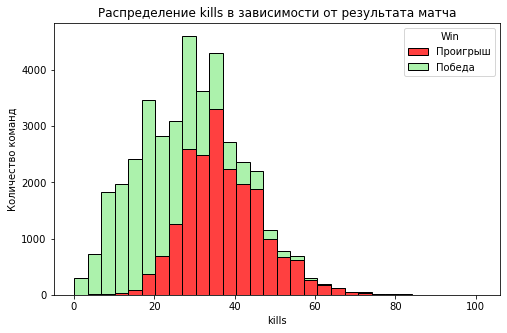

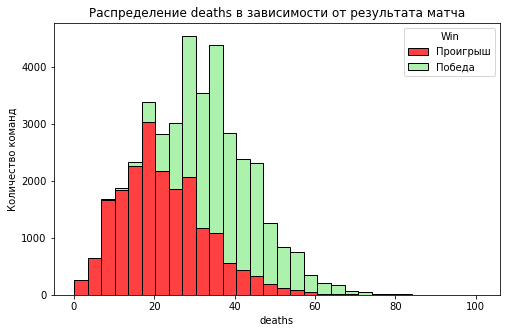

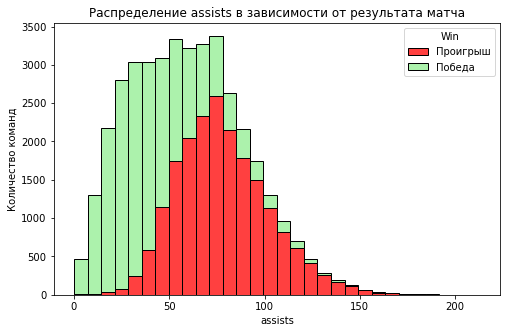

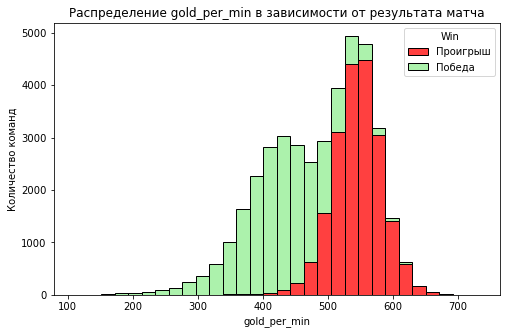

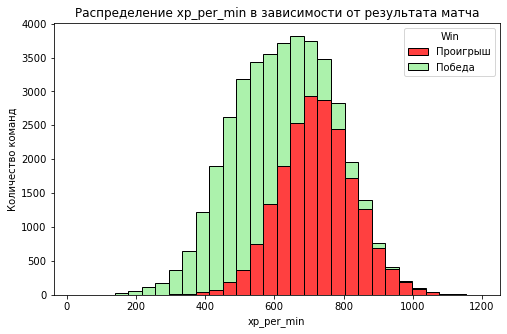

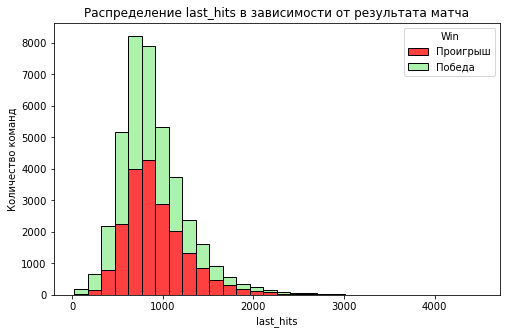

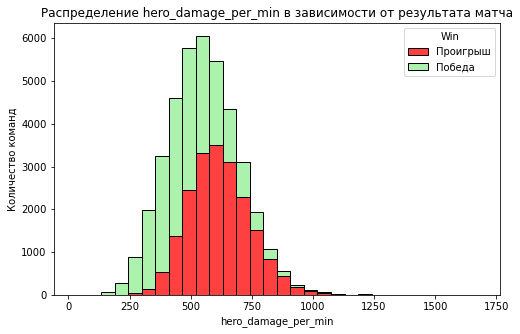

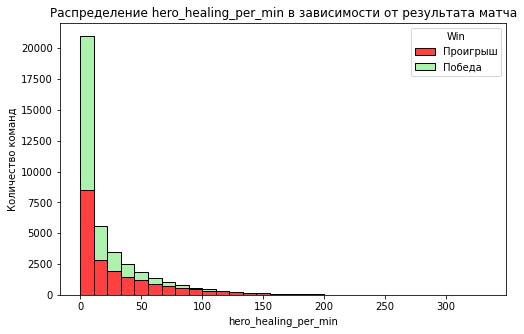

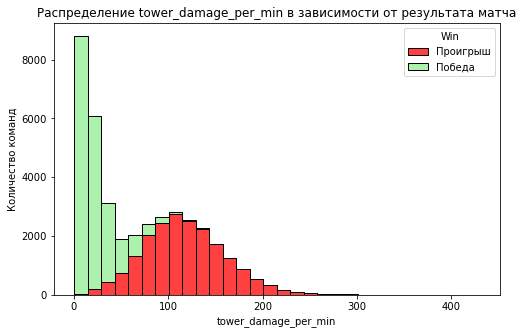

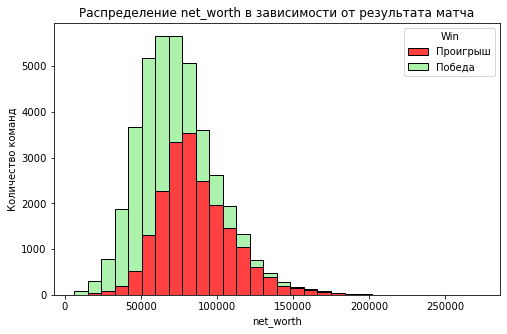

In [49]:
# Основные числовые параметры для анализа
metrics = [
    'kills',
    'deaths',
    'assists',
    'gold_per_min',
    'xp_per_min',
    'last_hits',
    'hero_damage_per_min',
    'hero_healing_per_min',
    'tower_damage_per_min',
    'net_worth'
]


for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df_team, 
        x=metric, 
        hue='win', 
        multiple='stack', 
        palette={1: 'red', 0: 'lightgreen'}, 
        bins=30
    )
    plt.title(f'Распределение {metric} в зависимости от результата матча')
    plt.xlabel(metric)
    plt.ylabel("Количество команд")
    plt.legend(title='Win', labels=['Проигрыш', 'Победа'])
    plt.show()


**📝ВЫВОД**:
1. Количество убийств (kills) больше у победивших команд
2. Количество смертей у победивших команд меньше
3. Чем больше ассистов, тем больше вероятность победы
4. Победившие команды фармят больше золота и получают опыта в большинстве случаев.
5. Средний и медианный уровень фарма примерно одинаковый, но вариация выше у победителей — они чаще “уходят в лейт” с доминированием по фарму
6. hero_damage выше у победителей, они наносят больше урона противнику
7. у большинства команд лечение минимальное (многие герои не обладают лечащими способностями)
8. Если команда наносит высокий удар по строениям, то она сбольшой вероятностью побеждает. Урон по башням — один из самых сильных предикторов победы.
9. Общий экономический показатель выше у победивших команд.


## 2 Основной анализ данных 

### 2.1 Влияние используемых предметов на исход игры

Посмотрим, какие предметы чаще приводят команду к победе: топ используемых в матчах предметов, в разрезе победителей / проигравших, какие предметы есть у победителей, которых нет у проигравших

In [50]:
df_players.head()

,match_id,account_id,player_slot,isRadiant,win,hero_id,level,kills,deaths,assists,...,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,item_neutral,team
0,8127690162,349310876,0,True,0,31,13,2,12,9,...,43,0,593,36,12,1127,0,0,298,Radiant
1,8127690162,1031547092,1,True,0,65,15,3,7,8,...,37,102,218,36,29,0,0,0,574,Radiant
2,8127690162,352545711,2,True,0,129,18,3,6,10,...,1,50,116,178,34,0,0,0,950,Radiant
3,8127690162,164685175,3,True,0,49,22,3,4,1,...,154,63,116,26,135,5,0,0,950,Radiant
4,8127690162,308163407,4,True,0,60,15,5,6,6,...,36,16,1107,73,116,0,0,0,950,Radiant


In [51]:
# Соберем все предметы в один столбец
items_cols = ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5','backpack_0', 'backpack_1','backpack_2']

df_with_items = df_players.melt(
    id_vars=['match_id', 'account_id', 'win'],
    value_vars=items_cols,
    var_name='slot',
    value_name='item_id'
).dropna(subset=['item_id'])
df_with_items.head(10)

,match_id,account_id,win,slot,item_id
0,8127690162,349310876,0,item_0,214
1,8127690162,1031547092,0,item_0,1
2,8127690162,352545711,0,item_0,41
3,8127690162,164685175,0,item_0,151
4,8127690162,308163407,0,item_0,50
5,8127690162,59463394,1,item_0,1
6,8127690162,252737052,1,item_0,112
7,8127690162,185202677,1,item_0,116
8,8127690162,248180032,1,item_0,240
9,8127690162,100758751,1,item_0,229


In [52]:
df_items.head()

,abilities,hint,id,img,dname,qual,cost,behavior,notes,attrib,...,created,charges,item_name,dmg_type,target_team,target_type,dispellable,bkbpierce,tier,desc
0,"[{'type': 'active', 'title': 'Blink', 'descrip...",[],1,/apps/dota2/images/dota_react/items/blink.png?...,Blink Dagger,component,2250.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,False,False,blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'type': 'active', 'title': 'Overwhelming Bli...",[],600,/apps/dota2/images/dota_react/items/overwhelmi...,Overwhelming Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,True,False,overwhelming_blink,Magical,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'type': 'active', 'title': 'Swift Blink', 'd...",[],603,/apps/dota2/images/dota_react/items/swift_blin...,Swift Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1200'}, {'ke...",...,True,False,swift_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'type': 'active', 'title': 'Arcane Blink', '...",[],604,/apps/dota2/images/dota_react/items/arcane_bli...,Arcane Blink,component,6800.0,Point Target,Self-casting will cause you to teleport in the...,"[{'key': 'blink_range', 'value': '1400'}, {'ke...",...,True,False,arcane_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,606,/apps/dota2/images/dota_react/items/recipe.png...,Arcane Blink Recipe,NaN,1750.0,False,,[],...,False,False,recipe_arcane_blink,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Подключаем справочник предметов
df_with_items = df_with_items.merge(df_items[['id', 'dname']], left_on='item_id', right_on='id', how='left')
df_with_items.head()


,match_id,account_id,win,slot,item_id,id,dname
0,8127690162,349310876,0,item_0,214,214.0,Tranquil Boots
1,8127690162,1031547092,0,item_0,1,1.0,Blink Dagger
2,8127690162,352545711,0,item_0,41,41.0,Bottle
3,8127690162,164685175,0,item_0,151,151.0,Armlet of Mordiggian
4,8127690162,308163407,0,item_0,50,50.0,Phase Boots


In [57]:
# Считаем, сколько раз предмет встречается у победителей и проигравших
item_counts = df_with_items.groupby(['dname', 'win']).size().unstack(fill_value=0)

# Добавим долю победителей и проигравших
item_counts['total'] = item_counts.sum(axis=1)
item_counts['win_rate'] = item_counts[1] / item_counts['total']  # если 1 = победа, иначе перевернуть


item_counts

win,0,1,total,win_rate
dname,,,,
Abyssal Blade,959,2138,3097,0.690345
Abyssal Blade Recipe,7,2,9,0.222222
Aegis of the Immortal,14,3511,3525,0.996028
Aeon Disk,529,955,1484,0.643531
Aeon Disk Recipe,30,56,86,0.651163
...,...,...,...,...
Wraith Band,5424,4201,9625,0.436468
Wraith Band Recipe,1,0,1,0.000000
Yasha,1486,725,2211,0.327906


In [55]:
#отберем топ предметов
top_items = (
    item_counts[item_counts['total'] > 100]  # отсеем редкие
    .sort_values('win_rate', ascending=False)
    .head(15)
)
print(top_items[['win_rate', 'total']])

win                    win_rate  total
dname                                 
Aegis of the Immortal  0.996028   3525
Gem of True Sight      0.901073   5873
Divine Rapier          0.880202    793
Refresher Shard        0.756654    263
Overwhelming Blink     0.743428    951
Cheese                 0.736215    671
Meteor Hammer          0.721212   1155
Swift Blink            0.715758   2329
Heart of Tarrasque     0.708738   1339
Moon Shard             0.700873    458
Satanic                0.696271   5337
Arcane Blink           0.691667    240
Abyssal Blade          0.690345   3097
Assault Cuirass        0.685236   5439
Octarine Core          0.683844   5880


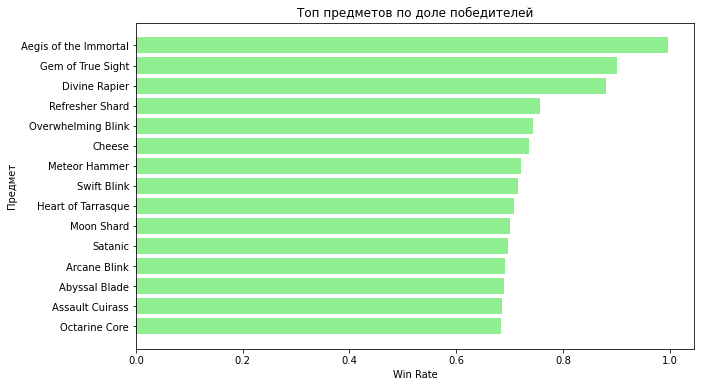

In [58]:
#визуализируем
top_items.sort_values('win_rate', inplace=True)
plt.figure(figsize=(10,6))
plt.barh(top_items.index, top_items['win_rate'], color='lightgreen')
plt.title('Топ предметов по доле победителей')
plt.xlabel('Win Rate')
plt.ylabel('Предмет')
plt.show()

**📝ВЫВОД**: В топе предметов победителей только поздние артефакты, которые появляются только у победителей, поэтому посмотрим предметы, которые встречаются и у победитлей, и у проигравших.

In [59]:
# Группируем по победе / поражению
item_usage = (
    df_with_items.groupby(['win', 'dname'])
    .size()
    .reset_index(name='count')
)

# Считаем долю внутри каждой категории (win=0 и win=1)
item_usage['share'] = item_usage.groupby('win')['count'].transform(lambda x: x / x.sum())
item_usage

,win,dname,count,share
0,0,Abyssal Blade,959,0.001556
1,0,Abyssal Blade Recipe,7,0.000011
2,0,Aegis of the Immortal,14,0.000023
3,0,Aeon Disk,529,0.000858
4,0,Aeon Disk Recipe,30,0.000049
...,...,...,...,...
568,1,Witch Blade,1547,0.002428
569,1,Wraith Band,4201,0.006594
570,1,Yasha,725,0.001138
571,1,Yasha Recipe,3,0.000005


In [60]:
# Победители
top_win = item_usage[item_usage['win'] == 0].sort_values('share', ascending=False).head(15)

# Проигравшие
top_lose = item_usage[item_usage['win'] == 1].sort_values('share', ascending=False).head(15)



In [61]:
unique_win_items = set(top_win['dname']) - set(top_lose['dname'])
unique_lose_items = set(top_lose['dname']) - set(top_win['dname'])

print("Предметы, встречающиеся в топе только у победителей:\n", unique_win_items)
print("\nПредметы, встречающиеся только у проигравших:\n", unique_lose_items)


Предметы, встречающиеся в топе только у победителей:
 {'Iron Branch'}

Предметы, встречающиеся только у проигравших:
 {'Force Staff'}


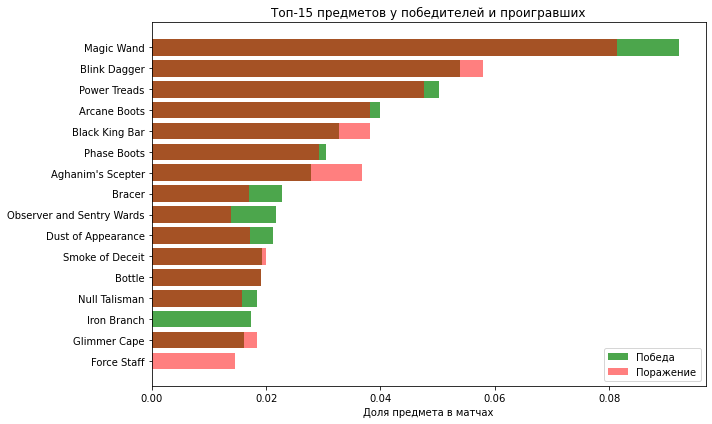

In [62]:
plt.figure(figsize=(10,6))
plt.barh(top_win['dname'], top_win['share'], color='green', alpha=0.7, label='Победа')
plt.barh(top_lose['dname'], top_lose['share'], color='red', alpha=0.5, label='Поражение')
plt.gca().invert_yaxis()
plt.xlabel('Доля предмета в матчах')
plt.title('Топ-15 предметов у победителей и проигравших')
plt.legend()
plt.tight_layout()
plt.show()

   **📝ВЫВОД**:
    Только у победителей встречается Iron Branch, возможно используется для максимизации стартовой эффективности
    Только у проигравших Force Staff, это может объясняться тем, что это инстумент защиты и его покупают экстренно в случае близкого поражения.
    По диаграмме нельзя делать выво, что использование того или иного предмета ведет к победе или поражению.

### 2.3 Анализ по героям
* Как вляет количество фарма на исход игры дл разных героев;
* Какие герои получают больше всего опыта за игру;
* Какие фракции чаще побеждают: свет или тьма;
* Каких героев чаще всего выбирают;
* Какие герои чаще всего выигрывают;
* Какие герои совершают больше всего убийств, ассистов;
* Какой герой меньше всего умирает;

#### 2.3.1 Влияние количества фарма на исход игры
Посмотрим, какой герой фармит больше всего золота: по всем матчам, есть ли разница в количестве золота нафармленного героем в разрезе победа / поражение

Посчитаем средний GPM (золото в минуту) по каждому герою


In [64]:
# Средний GPM по каждому герою
hero_gpm = (
    df_players.groupby('hero_id')['gold_per_min']
    .mean()
    .reset_index()
)

# Добавим названия героев
hero_gpm = hero_gpm.merge(
    heroes_merged[['id', 'localized_name']],
    left_on='hero_id', right_on='id',
    how='left'
)

# Отсортируем и посмотрим топ
hero_gpm = hero_gpm.sort_values('gold_per_min', ascending=False)
print(hero_gpm.head(10))

     hero_id  gold_per_min   id    localized_name
71        73    692.360759   73         Alchemist
92        94    689.747049   94            Medusa
44        46    688.201689   46  Templar Assassin
17        18    684.574074   18              Sven
46        48    673.207584   48              Luna
107      109    651.067705  109       Terrorblade
10        11    647.254545   11      Shadow Fiend
0          1    646.909763    1         Anti-Mage
9         10    646.270822   10         Morphling
111      113    646.112108  113        Arc Warden


По среднему GPM лидируют: Alchemist,  Medusa, Templar Assassin

In [65]:
# Средний GPM в разрезе побед / поражений
hero_gpm_winlose = (
    df_players.groupby(['hero_id', 'win'])['gold_per_min']
    .mean()
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
)
hero_gpm_winlose

,hero_id,win,gold_per_min,id,localized_name
0,1,0,555.891117,1,Anti-Mage
1,1,1,744.051988,1,Anti-Mage
2,2,0,455.581429,2,Axe
3,2,1,581.392546,2,Axe
4,3,0,259.938104,3,Bane
...,...,...,...,...,...
247,137,1,559.105263,137,Primal Beast
248,138,0,371.164118,138,Muerta
249,138,1,473.969989,138,Muerta
250,145,0,513.552632,145,Kez


In [66]:
# Перестроим таблицу для удобства
hero_gpm_pivot = hero_gpm_winlose.pivot_table(
    index='localized_name',
    columns='win',
    values='gold_per_min'
).rename(columns={0: 'Поражение', 1: 'Победа'})

hero_gpm_pivot['Разница'] = hero_gpm_pivot['Победа'] - hero_gpm_pivot['Поражение']
hero_gpm_pivot = hero_gpm_pivot.sort_values('Разница', ascending=False)
print(hero_gpm_pivot.head(20))


win                  Поражение      Победа     Разница
localized_name                                        
Meepo               503.572816  730.145631  226.572816
Medusa              594.566999  787.860731  193.293732
Spectre             486.203209  676.094891  189.891682
Anti-Mage           555.891117  744.051988  188.160870
Sven                594.407632  782.558907  188.151274
Morphling           558.023422  744.858931  186.835509
Gyrocopter          548.547032  732.131132  183.584100
Phantom Lancer      526.895455  710.186047  183.290592
Ursa                552.053090  731.548273  179.495183
Phantom Assassin    554.417476  732.681102  178.263627
Lone Druid          453.210526  628.670213  175.459686
Troll Warlord       549.655022  722.878641  173.223619
Bloodseeker         516.285714  685.333333  169.047619
Juggernaut          553.135440  721.836066  168.700625
Outworld Destroyer  472.386517  639.903226  167.516709
Necrophos           526.693790  693.440716  166.746926
Clinkz    

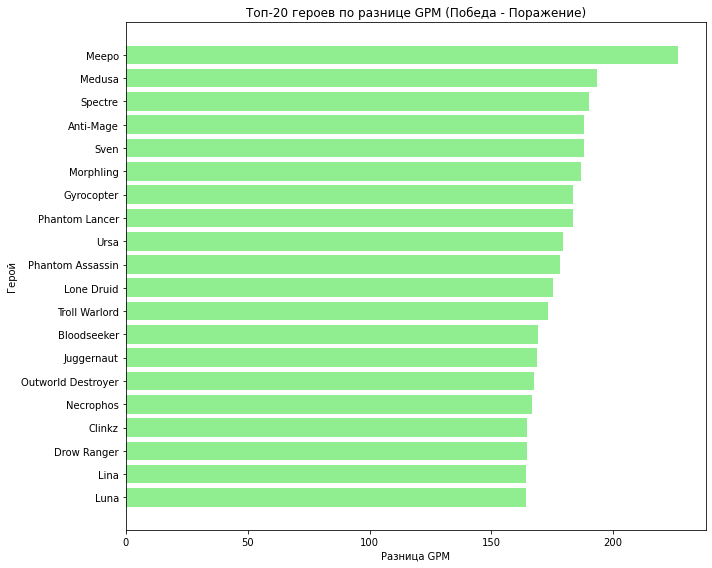

In [69]:
top20 = hero_gpm_pivot.head(20)

plt.figure(figsize=(10,8))
plt.barh(top20.index, top20['Разница'], color='lightgreen')
plt.gca().invert_yaxis()  # чтобы самый большой был сверху
plt.title("Топ-20 героев по разнице GPM (Победа - Поражение)")
plt.xlabel("Разница GPM")
plt.ylabel("Герой")
plt.tight_layout()
plt.show()

Самая больша разница между GPM (золото в минуту) при победе и поражении у Meepo, герой сильно зависит от экономического фактора.

In [67]:
print(hero_gpm_pivot.tail(20))

win                   Поражение      Победа    Разница
localized_name                                        
Silencer             278.784870  363.783205  84.998335
Lion                 270.132427  354.662029  84.529603
Dark Willow          289.780853  374.094896  84.314044
Ringmaster           276.950495  360.765595  83.815100
Oracle               257.799492  341.360202  83.560709
Witch Doctor         309.649635  393.100000  83.450365
Tusk                 270.978187  354.085476  83.107289
Clockwerk            271.232717  353.933464  82.700747
Keeper of the Light  391.412776  473.200385  81.787609
Ogre Magi            299.810462  381.455082  81.644620
Naga Siren           381.715116  462.914661  81.199545
Bane                 259.938104  340.642633  80.704529
Io                   272.188953  351.915033  79.726079
Ancient Apparition   291.762994  370.803554  79.040560
Chen                 324.005587  401.472340  77.466754
Crystal Maiden       262.679603  338.581774  75.902171
Disruptor 

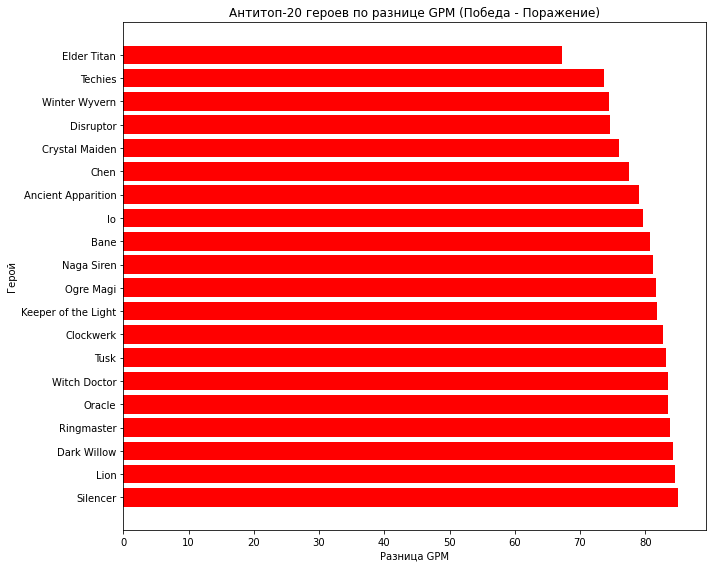

In [80]:
anti_top20 = hero_gpm_pivot.tail(20)

plt.figure(figsize=(10,8))
plt.barh(anti_top20.index, anti_top20['Разница'], color='red')

plt.title("Антитоп-20 героев по разнице GPM (Победа - Поражение)")
plt.xlabel("Разница GPM")
plt.ylabel("Герой")
plt.tight_layout()
plt.show()

Самая низкая зависимость от GPM у героя Elder Titan

**📝ВЫВОД**: Большая разница между фармом побед и поражений говорит о высокой зависимости от экономики, мальнкая разница наоборот говорит о том, что герой стабилен независимо от дохода, посмотрим, как связаны GPM c долей по побед у разных героев.

Можно выделить кластеры героев:

Высокий GPM + высокий Win rate

Высокий GPM + низкий Win rate

Низкий GPM + высокий Win rate

Низкий GPM + низкий Win rate

Посчитаем основные средние показатели: Золото в минуту,опыт в минуту, количество убийств, количество смертей, количество ассистов, количество побед и общее количество матчей для каждого героя.

In [83]:

# Агрегируем показатели по каждому герою
heroes_stats = (
    df_players.groupby('hero_id', as_index=False)
    .agg({
        'gold_per_min': 'mean',
        'xp_per_min': 'mean',
        'kills': 'mean',
        'deaths': 'mean',
        'assists': 'mean',
        'win': 'mean',  # среднее = винрейт, т.к. win = 1/0
        'match_id': 'nunique'
    })
    .rename(columns={'win': 'win_rate', 'match_id': 'matches_played'})
)

# Добавим KDA
heroes_stats['KDA'] = (heroes_stats['kills'] + heroes_stats['assists']) / heroes_stats['deaths'].replace(0, 1)



In [84]:
heroes_short = heroes_merged[['id', 'localized_name']].rename(columns={'id': 'hero_id'})
gpm_vs_win = heroes_stats.merge(heroes_short, on='hero_id', how='left')

In [85]:
print(gpm_vs_win.head())

   hero_id  gold_per_min  xp_per_min     kills    deaths    assists  win_rate  \
0        1    646.909763  836.686391  7.869822  4.266272   7.164201  0.483728   
1        2    515.201052  657.189402  8.198046  7.031191   9.579481  0.473882   
2        3    304.517749  460.311688  3.352381  7.914286  15.929870  0.552381   
3        4    595.051771  749.193460  7.664850  5.504087   9.155313  0.465940   
4        5    302.595635  451.716731  2.507916  7.668806  12.680359  0.525888   

   matches_played       KDA  localized_name  
0             676  3.523925       Anti-Mage  
1            2661  2.528381             Axe  
2            1155  2.436386            Bane  
3             367  3.055941     Bloodseeker  
4            2337  1.980527  Crystal Maiden  


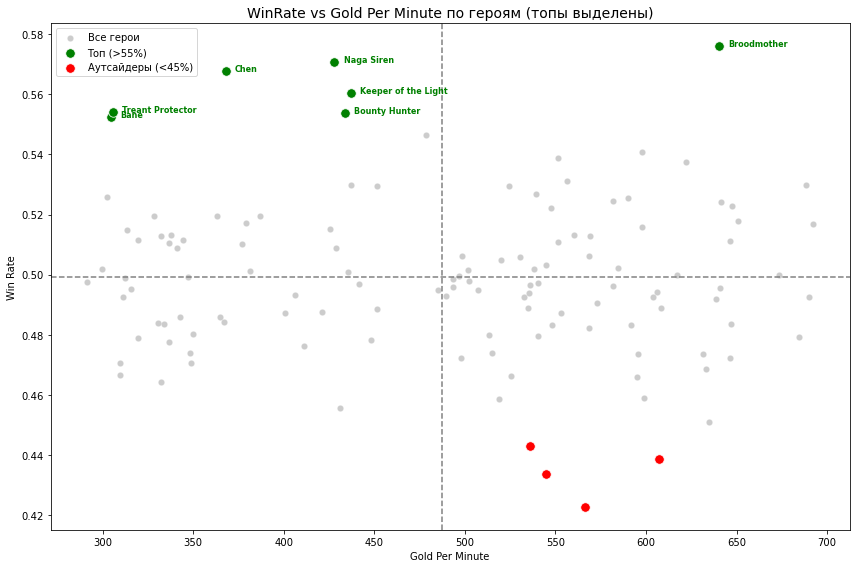

In [86]:
top = gpm_vs_win[gpm_vs_win['win_rate'] > 0.55]
bottom = gpm_vs_win[gpm_vs_win['win_rate'] < 0.45]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=gpm_vs_win, x='gold_per_min', y='win_rate',
                color='gray', alpha=0.4, s=40, label='Все герои')

sns.scatterplot(data=top, x='gold_per_min', y='win_rate',
                color='green', s=90, label='Топ (>55%)')
sns.scatterplot(data=bottom, x='gold_per_min', y='win_rate',
                color='red', s=90, label='Аутсайдеры (<45%)')

for _, row in top.iterrows():
    plt.text(row['gold_per_min'] + 5, row['win_rate'], row['localized_name'],
             fontsize=8, color='green', weight='bold')

plt.axvline(gpm_vs_win['gold_per_min'].mean(), color='gray', linestyle='--')
plt.axhline(gpm_vs_win['win_rate'].mean(), color='gray', linestyle='--')

plt.title('WinRate vs Gold Per Minute по героям (топы выделены)', fontsize=14)
plt.xlabel('Gold Per Minute')
plt.ylabel('Win Rate')
plt.legend()
plt.tight_layout()
plt.show()


**📝ВЫВОД**:

* Нет жёсткой линейной связи между фармом и победами:
  видно, что герои с высоким GPM (600–700) не всегда побеждают чаще.
  → То есть большое золото не гарантирует победу.

* Множество героев с умеренным GPM (400–500) имеют высокий winrate — они эффективно используют ресурсы, даже если фармят меньше.

* Герои с высоким winrate и низким GPM

Например: Treant Protector, Chen, Bane, Crystal Maiden, Naga Siren.

Это саппорты и герои контроля, у которых мало фарма,
но огромный вклад в победу за счёт умений и командной пользы.

Такие герои часто определяют исход игры не деньгами, а тактикой.

* Герои с высоким GPM, но низким winrate

Phantom Assassin, Anti-Mage, Sven, Medusa, Troll Warlord.

Это типичные “жадные керри”, которые фармят много,
но если игра затягивается или команда проигрывает по карте,
их золото не успевает реализоваться.

Это часто говорит о зависимости от команды и темпа игры.

* Балансированные лидеры

Broodmother, Nature’s Prophet, Templar Assassin, Juggernaut.

У них высокий GPM и высокий winrate.

Это самодостаточные герои, способные и фармить, и давить карту.

Обычно такие герои сильны на всех стадиях игры, что делает их “метовыми”.

💬 Итоговые выводы

Фарм сам по себе не выигрывает игру — важна эффективность реализации.

Поддержка и контроль (Bane, Treant, Chen) дают стабильный результат даже при низкой экономике.

Герои-фермеры часто выглядят впечатляюще по GPM, но требуют идеальных условий.

Оптимальные победные стратегии опираются на героев, совмещающих экономику и влияние — Broodmother, Prophet, Juggernaut, TA.

#### 2.3.2 Анализ опыта героев

In [87]:
# Средний XPM по каждому герою
hero_xpm = (
    df_players.groupby('hero_id')['xp_per_min']
    .mean()
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
    .sort_values('xp_per_min', ascending=False)
)

print(hero_xpm.head(10))

    hero_id  xp_per_min  id    localized_name
17       18  877.695574  18              Sven
44       46  873.902703  46  Templar Assassin
0         1  836.686391   1         Anti-Mage
23       25  824.367308  25              Lina
10       11  820.188531  11      Shadow Fiend
68       70  815.638279  70              Ursa
92       94  810.757167  94            Medusa
46       48  807.794987  48              Luna
80       82  800.344660  82             Meepo
42       44  799.308467  44  Phantom Assassin


In [88]:
# Средний XPM в разрезе побед / поражений
hero_xpm_winlose = (
    df_players.groupby(['hero_id', 'win'])['xp_per_min']
    .mean()
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
)

# Строим таблицу для удобства
hero_xpm_pivot = hero_xpm_winlose.pivot_table(
    index='localized_name',
    columns='win',
    values='xp_per_min'
).rename(columns={0: 'Поражение', 1: 'Победа'})

# Добавим разницу
hero_xpm_pivot['Разница'] = hero_xpm_pivot['Победа'] - hero_xpm_pivot['Поражение']
hero_xpm_pivot = hero_xpm_pivot.sort_values('Победа', ascending=False)
print(hero_xpm_pivot.head(10))


win                Поражение       Победа     Разница
localized_name                                       
Sven              761.707719  1003.740811  242.033092
Meepo             616.640777   984.048544  367.407767
Anti-Mage         712.974212   968.721713  255.747501
Templar Assassin  773.403017   963.121811  189.718794
Lina              713.751508   949.812585  236.061078
Ursa              687.206266   946.345438  259.139172
Spectre           611.935829   944.605839  332.670011
Phantom Assassin  689.847896   932.471129  242.623232
Medusa            695.192691   929.883562  234.690871
Phantom Lancer    645.240909   922.075581  276.834672


In [89]:
print(hero_xpm_pivot.tail(10))

win                Поражение      Победа     Разница
localized_name                                      
Elder Titan       423.128205  528.420339  105.292134
Lich              368.147126  526.075829  157.928703
Shadow Shaman     372.722357  522.462825  149.740468
Clockwerk         376.331061  522.423679  146.092618
Silencer          374.708432  521.311911  146.603479
Treant Protector  377.914286  518.609195  140.694910
Crystal Maiden    382.218412  514.372661  132.154249
Oracle            360.868020  506.471033  145.603012
Disruptor         366.809271  503.311350  136.502079
Chen              354.893855  486.948936  132.055081


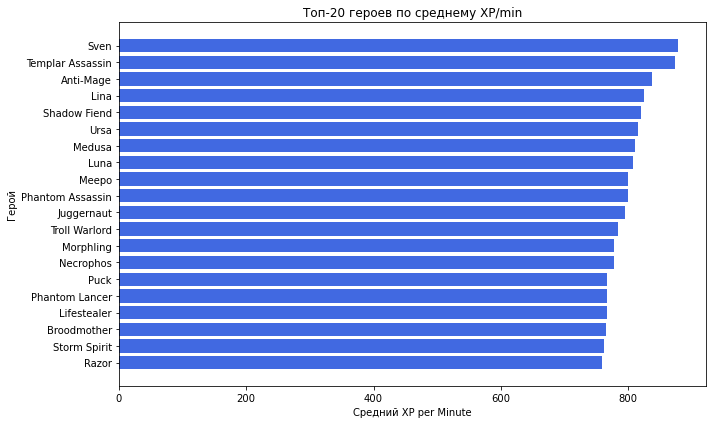

In [90]:
# средний XP/min по каждому герою
hero_xpm = (
    df_players.groupby('hero_id')['xp_per_min']
    .mean()
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
    .sort_values('xp_per_min', ascending=False)
)

# берём, например, топ-20 героев
top_xpm = hero_xpm.head(20)

# строим график
plt.figure(figsize=(10, 6))
plt.barh(top_xpm['localized_name'], top_xpm['xp_per_min'], color='royalblue')
plt.gca().invert_yaxis()  # чтобы сверху были самые большие значения
plt.title('Топ-20 героев по среднему XP/min')
plt.xlabel('Средний XP per Minute')
plt.ylabel('Герой')
plt.tight_layout()
plt.show()


**📝ВЫВОД**:
Разница в XP/min между топ-героями незначительна,
значит, темп прокачки не является решающим фактором победы —
важнее то, как герой использует свои уровни (уровень урона, ультимейты, мобильность и т.д.).

#### 2.3.3 Какие фракции чаще побеждают: свет или тьма

In [91]:
df_matches.head()

,match_id,duration_sec,duration_min,radiant_win,game_mode,start_time,league_name,first_blood_time,region
0,8127690162,1996,33.3,False,2,1736784566,Неизвестно,81,NaN
1,8127691029,1896,31.6,False,2,1736784425,Неизвестно,151,6.0
2,8127718999,1933,32.2,True,2,1736785630,Неизвестно,273,3.0
3,8127724795,2330,38.8,False,2,1736786298,Неизвестно,0,3.0
4,8127745833,1470,24.5,False,2,1736786730,Неизвестно,0,3.0


In [92]:
# Считаем количество побед Radiant и Dire
radiant_wins = df_matches['radiant_win'].sum()
dire_wins = len(df_matches) - radiant_wins

# Вычисляем проценты
total = len(df_matches)
radiant_winrate = radiant_wins / total * 100
dire_winrate = dire_wins / total * 100

print(f"Radiant (Свет) побеждает в {radiant_winrate:.1f}% матчей")
print(f"Dire (Тьма) побеждает в {dire_winrate:.1f}% матчей")


Radiant (Свет) побеждает в 52.3% матчей
Dire (Тьма) побеждает в 47.7% матчей


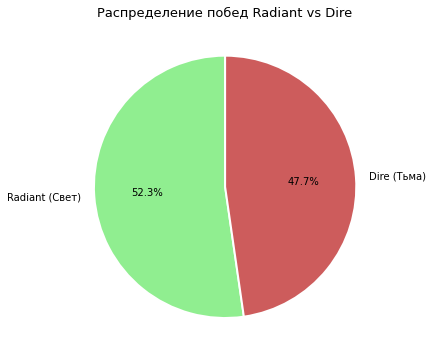

In [94]:
factions = ['Radiant (Свет)', 'Dire (Тьма)']
winrates = [radiant_winrate, dire_winrate]
colors = ['lightgreen', 'indianred']

plt.figure(figsize=(6, 6))
plt.pie(
    winrates,
    labels=factions,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
plt.title('Распределение побед Radiant vs Dire', fontsize=13)
plt.tight_layout()
plt.show()


**📝ВЫВОД:** Побед света примерно на 5% больше.

#### 2.3.4 Каких героев чаще всего выбирают

In [95]:
# Подсчёт количества появлений каждого героя
hero_picks = (
    df_players['hero_id']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'hero_id', 'hero_id': 'count'})
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
    .sort_values('count', ascending=False)
)

print(hero_picks.head(15))


    hero_id  count   id    localized_name
0        86   4608   86            Rubick
1        19   4240   19              Tiny
2        64   3810   64            Jakiro
3        11   3575   11      Shadow Fiend
4        39   3417   39     Queen of Pain
5        53   3388   53  Nature's Prophet
6        27   3260   27     Shadow Shaman
7        21   3188   21        Windranger
8       106   3114  106      Ember Spirit
9       100   3023  100              Tusk
10       84   2997   84         Ogre Magi
11       46   2960   46  Templar Assassin
12      109   2954  109       Terrorblade
13       14   2928   14             Pudge
14      129   2928  129              Mars


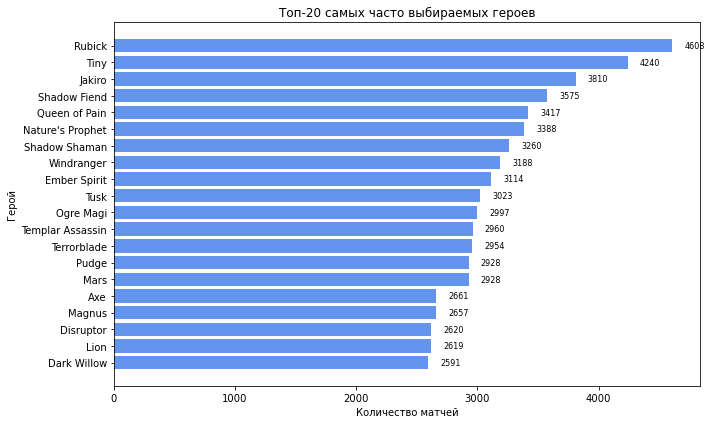

In [96]:
top_picks = hero_picks.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_picks['localized_name'], top_picks['count'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Топ-20 самых часто выбираемых героев')
plt.xlabel('Количество матчей')
plt.ylabel('Герой')

# Добавим подписи к столбцам
for i, v in enumerate(top_picks['count']):
    plt.text(v + 100, i, str(v), va='center', fontsize=8)

plt.tight_layout()
plt.show()


**📝ВЫВОД:** 
* Самые популярные герои Rubick, Tiny, Jakiro.
* В топ-20 есть керри (Templar Assassin, Terrorblade), мидеры (SF, QoP, Ember), оффлейнеры (Mars, Axe), саппорты (Rubick, Jakiro, Disruptor, Lion). Это говорит о сбалансированной мета-сцене, где нет абсолютного “имба”-героя, а набор популярных персонажей охватывает все роли.
* Популярные герои часто имеют средние GPM и XP

#### 2.3.5 Какие герои чаще всего выигрывают

In [97]:
hero_stats_win = (
    df_players.groupby('hero_id')
    .agg(
                winrate=('win', 'mean')
    )
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
).sort_values('winrate', ascending=False)
print(hero_stats_win.head(15))

     hero_id   winrate   id       localized_name
59        61  0.575875   61          Broodmother
87        89  0.570537   89           Naga Siren
64        66  0.567633   66                 Chen
88        90  0.560475   90  Keeper of the Light
81        83  0.554140   83     Treant Protector
60        62  0.553696   62        Bounty Hunter
2          3  0.552381    3                 Bane
31        33  0.546392   33               Enigma
75        77  0.540750   77                Lycan
112      114  0.538620  114          Monkey King
51        53  0.537485   53     Nature's Prophet
97        99  0.531196   99          Bristleback
122      136  0.529744  136                Marci
44        46  0.529730   46     Templar Assassin
38        40  0.529540   40           Venomancer


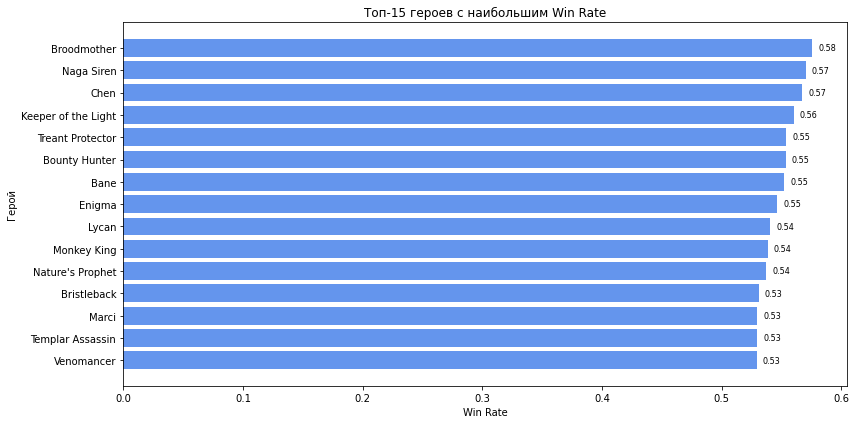

In [98]:
top_wins = hero_stats_win.head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_wins['localized_name'], top_wins['winrate'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Топ-15 героев с наибольшим Win Rate')
plt.xlabel('Win Rate')
plt.ylabel('Герой')

# Добавляем подписи к столбцам
for i, v in enumerate(top_wins['winrate']):
    plt.text(v + 0.005, i, f'{v:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()


**📝ВЫВОД:** Broodmother — лидер по винрейту (58 %), но разброс winrate по топ-15 небольшой, тол есть нет явных лидеров, героев, которые обеспечивают высокую вероятность победы. Посмотрим, какие герои часто выбираются и при этом действительно выигрывают.

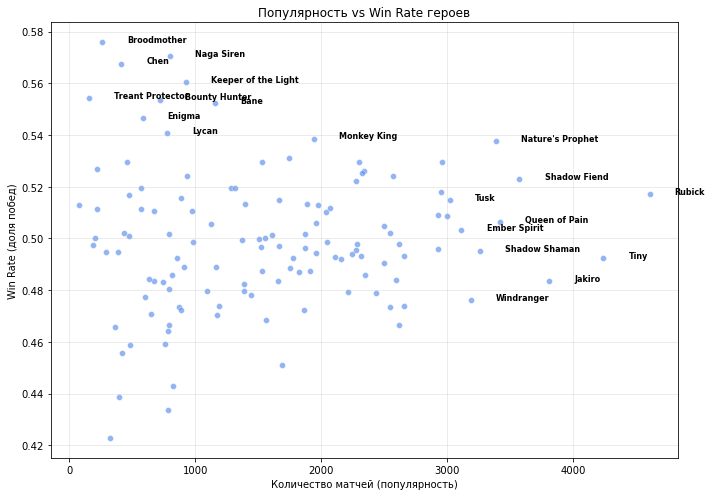

In [99]:
#Подсчёт количества игр и среднего Win Rate для каждого героя
hero_stats = (
    df_players.groupby('hero_id')
    .agg(
        matches=('hero_id', 'count'),
        winrate=('win', 'mean')
    )
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
)

# График
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=hero_stats,
    x='matches', 
    y='winrate', 
    alpha=0.7,
    color='cornflowerblue'
)

# Подписи для самых популярных и эффективных героев
top_popular = hero_stats.nlargest(10, 'matches')
top_winners = hero_stats.nlargest(10, 'winrate')
highlight = pd.concat([top_popular, top_winners]).drop_duplicates(subset='hero_id')

for _, row in highlight.iterrows():
    plt.text(
        row['matches'] + 200,
        row['winrate'],
        row['localized_name'],
        fontsize=8,
        weight='bold'
    )

plt.title('Популярность vs Win Rate героев')
plt.xlabel('Количество матчей (популярность)')
plt.ylabel('Win Rate (доля побед)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**📝ВЫВОД:**
 1. Герои с высоким Win Rate, но низкой популярностью

(левый верхний угол: Broodmother, Chen, Naga Siren, Treant, Keeper of the Light)

Эти герои редко выбираются, но побеждают часто.

Обычно они сложнее в освоении и требуют командной координации.

2. Герои с высокой популярностью, но средним или низким Win Rate

(правый нижний угол: Rubick, Jakiro, Tiny, Windranger)

Их часто выбирают из-за универсальности или простоты, но они не дают максимальный результат.

Вывод: популярность ≠ эффективность.
Игроки часто берут удобных, а не результативных героев.

3. Балансированные герои — “золотая середина”

(центр: Monkey King, Nature’s Prophet, Shadow Fiend)

Играются часто и дают стабильный результат (Win Rate ≈ 0.52–0.54).

Обычно это мета-герои с гибкой ролью: могут фармить, инициировать и пушить.
4. Общая тенденция

График почти плоский по наклону — сильной корреляции между частотой выбора и Win Rate нет.
Это подтверждает, что в Dota 2 не существует “обязательных для победы” героев — результат определяется умением игроков и составом команды.

#### 2.3.6 Какие герои совершают больше всего убийств, ассистов

In [100]:
df_players.head()

,match_id,account_id,player_slot,isRadiant,win,hero_id,level,kills,deaths,assists,...,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,item_neutral,team
0,8127690162,349310876,0,True,0,31,13,2,12,9,...,43,0,593,36,12,1127,0,0,298,Radiant
1,8127690162,1031547092,1,True,0,65,15,3,7,8,...,37,102,218,36,29,0,0,0,574,Radiant
2,8127690162,352545711,2,True,0,129,18,3,6,10,...,1,50,116,178,34,0,0,0,950,Radiant
3,8127690162,164685175,3,True,0,49,22,3,4,1,...,154,63,116,26,135,5,0,0,950,Radiant
4,8127690162,308163407,4,True,0,60,15,5,6,6,...,36,16,1107,73,116,0,0,0,950,Radiant


In [101]:
hero_stats_kill = (
    df_players.groupby('hero_id')
    .agg(
                kills_mean=('kills', 'mean'),
                assists_mean=('assists','mean')
    )
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
).sort_values('kills_mean', ascending=False)
print(hero_stats_kill.head(15))

     hero_id  kills_mean  assists_mean   id      localized_name
54        56    9.947248     11.706422   56              Clinkz
65        67    9.546296     13.098765   67             Spectre
68        70    9.404302      6.816067   70                Ursa
37        39    9.330992     10.707346   39       Queen of Pain
50        52    9.057481     11.029838   52             Leshrac
96        98    8.797455     10.451750   98           Timbersaw
14        15    8.577528     10.391011   15               Razor
34        36    8.567834      8.882932   36           Necrophos
33        35    8.456798      9.787915   35              Sniper
16        17    8.401439     10.051579   17        Storm Spirit
44        46    8.366892      7.642568   46    Templar Assassin
74        76    8.324427      6.572519   76  Outworld Destroyer
112      114    8.291452     10.498455  114         Monkey King
104      106    8.275530     12.403340  106        Ember Spirit
42        44    8.228538      7.428064  

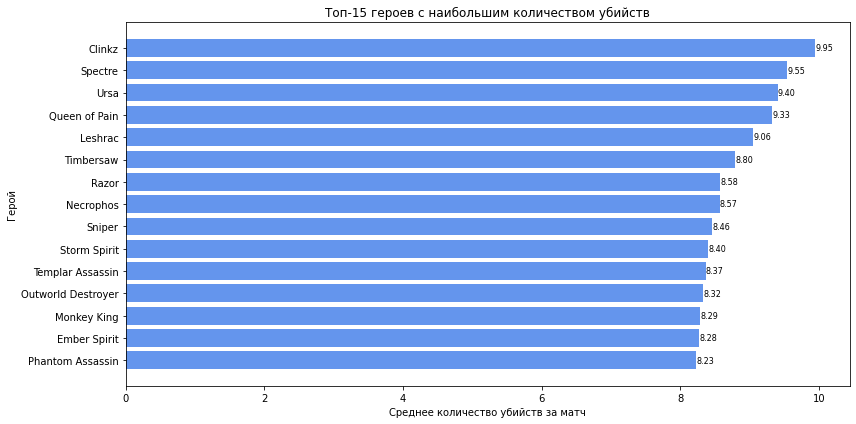

In [102]:
top_kills = hero_stats_kill.head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_kills['localized_name'], top_kills['kills_mean'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Топ-15 героев с наибольшим количеством убийств')
plt.xlabel('Среднее количество убийств за матч')
plt.ylabel('Герой')

# Добавляем подписи к столбцам
for i, v in enumerate(top_kills['kills_mean']):
    plt.text(v + 0.005, i, f'{v:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

**📝ВЫВОД:**
Больше всего убийств совершают герои Clinkz, Spectre, Ursa, Queen of Pain и Leshrac. Герои с наибольшим количеством убийств — не всегда самые победоносные.

In [103]:
hero_stats_assists = (
    df_players.groupby('hero_id')
    .agg(
                assists_mean=('assists','mean')
    )
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
).sort_values('assists_mean', ascending=False)
print(hero_stats_assists.head(15))

     hero_id  assists_mean   id      localized_name
85        87     16.860687   87           Disruptor
89        91     16.786154   91                  Io
66        68     16.333165   68  Ancient Apparition
60        62     16.195258   62       Bounty Hunter
69        71     16.108696   71      Spirit Breaker
73        75     15.945813   75            Silencer
2          3     15.929870    3                Bane
49        51     15.692533   51           Clockwerk
98       100     15.683758  100                Tusk
101      103     15.628521  103         Elder Titan
81        83     15.605096   83    Treant Protector
115      121     15.459079  121          Grimstroke
83        85     15.356495   85             Undying
77        79     15.157970   79        Shadow Demon
87        89     15.079900   89          Naga Siren


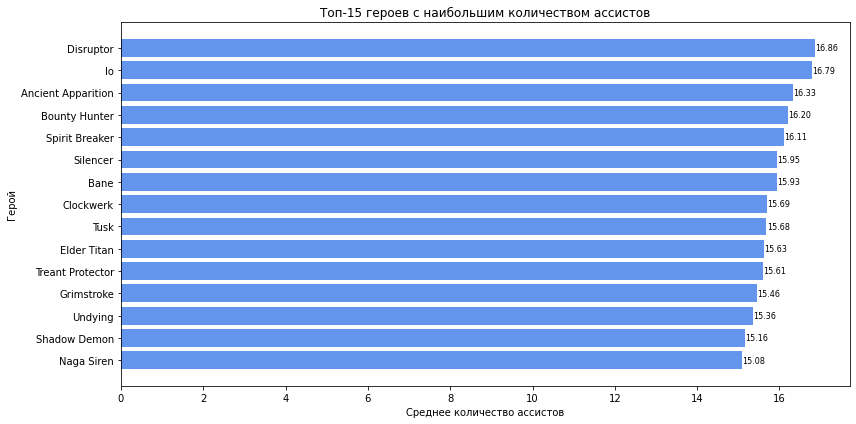

In [104]:
top_assists = hero_stats_assists.head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_assists['localized_name'], top_assists['assists_mean'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Топ-15 героев с наибольшим количеством ассистов')
plt.xlabel('Среднее количество ассистов')
plt.ylabel('Герой')

# Добавляем подписи к столбцам
for i, v in enumerate(top_assists['assists_mean']):
    plt.text(v + 0.005, i, f'{v:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

**📝ВЫВОД:** Абсолютные лидеры — Disruptor и Io

#### 2.3.7 Какой герой меньше всего умирает

In [105]:
hero_stats_deaths = (
    df_players.groupby('hero_id')
    .agg(
                deaths_mean=('deaths','mean')
    )
    .reset_index()
    .merge(heroes_merged[['id', 'localized_name']], left_on='hero_id', right_on='id', how='left')
).sort_values('deaths_mean', ascending=True)
print(hero_stats_deaths.head(15))

     hero_id  deaths_mean   id    localized_name
75        77     3.397154   77             Lycan
92        94     3.666667   94            Medusa
52        54     3.810010   54       Lifestealer
44        46     4.127703   46  Templar Assassin
9         10     4.210639   10         Morphling
0          1     4.266272    1         Anti-Mage
12        13     4.341767   13              Puck
64        66     4.345411   66              Chen
47        49     4.376817   49     Dragon Knight
117      126     4.394154  126       Void Spirit
17        18     4.447606   18              Sven
107      109     4.509140  109       Terrorblade
16        17     4.546182   17      Storm Spirit
78        80     4.566138   80        Lone Druid
40        42     4.571841   42       Wraith King


In [ ]:
top_deaths = hero_stats_deaths.head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_deaths['localized_name'], top_deaths['deaths_mean'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Топ-15 героев с наименьшим количеством смертей')
plt.xlabel('Среднее количество смертей')
plt.ylabel('Герой')

# Добавляем подписи к столбцам
for i, v in enumerate(top_deaths['deaths_mean']):
    plt.text(v + 0.005, i, f'{v:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

**📝ВЫВОД:** 
Самые “живучие” герои — Lycan, Medusa, Lifestealer. Герои, которые меньше умирают, — это не обязательно самые сильные бойцы,но они часто определяют стабильность команды. Это так называемые танки, много жизней, брони или lifesteal, что позволяет им выживать в командных боях.

### 2.4 Анализ матчей


Какие герои могут повлиять на исход матча (наличие carry в столбце роль) в долгих играх (больше 50 минут)

#### 2.4.1 Сколько в среднем длится матч

In [108]:
    # Добавим длительность в минутах
    df_matches['duration_min'] = df_matches['duration_sec'] / 60

    # Средняя и медианная длительность
    mean_duration = df_matches['duration_min'].mean()
    median_duration = df_matches['duration_min'].median()

    print(f" Средняя длительность матча: {mean_duration:.1f} минут")
    print(f"Медианная длительность матча: {median_duration:.1f} минут")



 Средняя длительность матча: 33.5 минут
Медианная длительность матча: 31.6 минут


#### 2.4.2 Среднее время до первой крови + гистограмма

In [109]:
df_matches.head()

,match_id,duration_sec,duration_min,radiant_win,game_mode,start_time,league_name,first_blood_time,region
0,8127690162,1996,33.266667,False,2,1736784566,Неизвестно,81,NaN
1,8127691029,1896,31.600000,False,2,1736784425,Неизвестно,151,6.0
2,8127718999,1933,32.216667,True,2,1736785630,Неизвестно,273,3.0
3,8127724795,2330,38.833333,False,2,1736786298,Неизвестно,0,3.0
4,8127745833,1470,24.500000,False,2,1736786730,Неизвестно,0,3.0


Среднее время до первой крови: 2.20 мин
Медиана: 1.85 мин


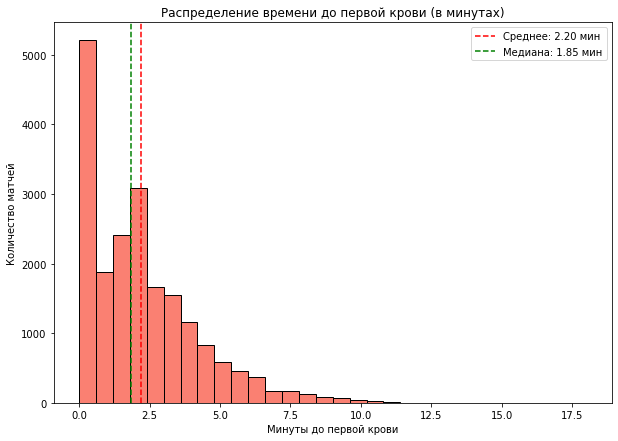

In [112]:
    # Переведём секунды в минуты
    df_matches['first_blood_min'] = df_matches['first_blood_time'] / 60

    # Среднее и медиана
    mean_fb = df_matches['first_blood_min'].mean()
    median_fb = df_matches['first_blood_min'].median()

    print(f"Среднее время до первой крови: {mean_fb:.2f} мин")
    print(f"Медиана: {median_fb:.2f} мин")

    # Гистограмма
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,7))
    plt.hist(df_matches['first_blood_min'], bins=30, color='salmon', edgecolor='black')
    plt.axvline(mean_fb, color='red', linestyle='--', label=f'Среднее: {mean_fb:.2f} мин')
    plt.axvline(median_fb, color='green', linestyle='--', label=f'Медиана: {median_fb:.2f} мин')
    plt.title('Распределение времени до первой крови (в минутах)')
    plt.xlabel('Минуты до первой крови')
    plt.ylabel('Количество матчей')
    plt.legend()
    plt.show()



**📝ВЫВОД:** В среднем, первая кровь происходит на 1–2 минуте,что говорит о динамичной и агрессивной мете. Но длинный хвост указывает на то, что есть матчи, где время до первой крови более 5 минут.

#### 2.4.3 Найдем 10 топовых игроков по проценту побед: отличаются ли статы в их матчах от матчей, где их нет

Найдем Топ 10 игроков по количеству побед

In [113]:
# Группируем по игрокам (account_id)
player_stats = (
    df_players.groupby('account_id')
    .agg(
        total_matches=('match_id', 'count'),
        winrate=('win', 'mean')
    )
    .reset_index()
)

# Берём только тех, кто сыграл хотя бы несколько матчей
player_stats = player_stats[player_stats['total_matches'] >= 10]

# Топ-10 по винрейту
top_players = player_stats.sort_values('winrate', ascending=False).head(10)
print(top_players)


      account_id  total_matches   winrate
346     92131659             11  1.000000
691    114585639             10  1.000000
2254   189892277             10  1.000000
3256   308344413             14  1.000000
1045   129638352             10  1.000000
7349  1849875747             14  1.000000
3683   355514054             10  1.000000
2600   215111583             18  0.944444
5841  1157907397             16  0.937500
3077   284961240             15  0.933333


Отберем все матчи этих игроков

In [114]:
# Список ID топ-10 игроков
top_ids = top_players['account_id'].tolist()

# Матчи с участием топ-игроков
df_top = df_players[df_players['account_id'].isin(top_ids)]

# Матчи остальных игроков
df_others = df_players[~df_players['account_id'].isin(top_ids)]


In [115]:
# Средние показатели
cols_to_compare = ['kills', 'deaths', 'assists', 'gold_per_min', 'xp_per_min', 'hero_damage']

mean_top = df_top[cols_to_compare].mean()
mean_others = df_others[cols_to_compare].mean()

comparison = pd.DataFrame({
    'Топ-игроки': mean_top,
    'Остальные': mean_others,
    'Разница': mean_top - mean_others
}).round(2)

print(comparison)

              Топ-игроки  Остальные  Разница
kills               8.41       5.88     2.53
deaths              3.80       6.00    -2.21
assists            17.68      11.98     5.70
gold_per_min      567.63     484.98    82.65
xp_per_min        727.28     631.93    95.35
hero_damage     21939.94   18868.52  3071.42


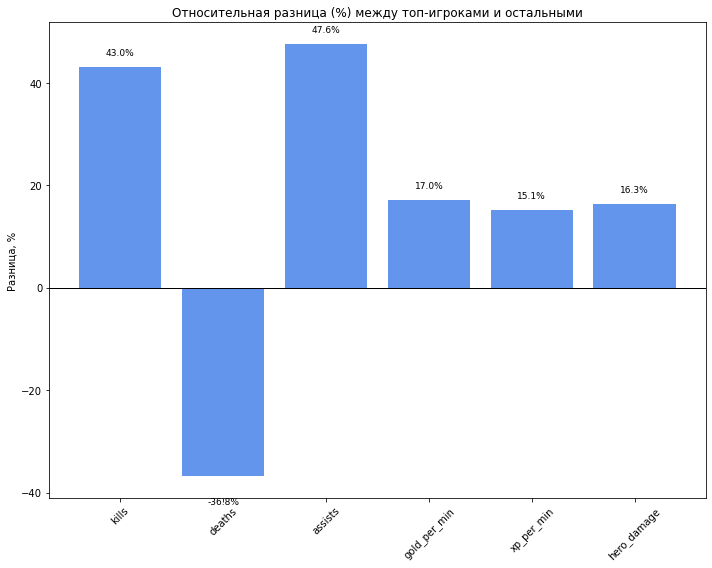

In [116]:
# Переводим разницу в относительные проценты
comparison['Разница (%)'] = (comparison['Разница'] / comparison['Остальные']) * 100

# Строим график
plt.figure(figsize=(10, 8))
plt.bar(comparison.index, comparison['Разница (%)'], color='cornflowerblue')

# Добавляем подписи
for i, v in enumerate(comparison['Разница (%)']):
    plt.text(i, v + (2 if v > 0 else -4), f'{v:.1f}%', ha='center', va='bottom' if v > 0 else 'top', fontsize=9)

# Оформление
plt.axhline(0, color='black', linewidth=1)
plt.title('Относительная разница (%) между топ-игроками и остальными')
plt.ylabel('Разница, %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**📝ВЫВОД:** Топ-игроки соврешают на 43% больше убийств и на 47% больше ассистов. Получеают на 17% больше золота в минуту, на 15% больше опыта и на 16% больше наносят урона, чем остальные.

#### 2.4.4 Влияет ли средний процент побед игроков в команде на победу команды

Посчитаем средний рейтинг побед winrate игроков для каждой команды в каждом матче

In [117]:
# Средний процент побед каждого игрока
player_winrate = (
    df_players.groupby('account_id')['win']
    .mean()
    .reset_index()
    .rename(columns={'win': 'player_winrate'})
)

# Присоединяем к основной таблице
df_with_wr = df_players.merge(player_winrate, on='account_id', how='left')


Агрегируем по матчам и командам

In [118]:
# Средний winrate игроков в каждой команде (в матче)
team_wr = (
    df_with_wr.groupby(['match_id', 'isRadiant'])
    .agg(
        team_avg_wr=('player_winrate', 'mean'),
        team_win=('win', 'max')  # win одинаковый для всей команды
    )
    .reset_index()
)

Проверим зависимость: влияет ли средний рейтинг побед игроков в команде на рейтинг побед команды вцелом.

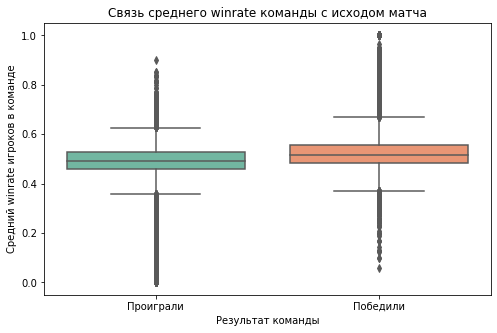

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=team_wr, x='team_win', y='team_avg_wr', palette='Set2')
plt.xticks([0,1], ['Проиграли', 'Победили'])
plt.title('Связь среднего winrate команды с исходом матча')
plt.xlabel('Результат команды')
plt.ylabel('Средний winrate игроков в команде')
plt.show()


Проверим, связан ли средний личный win rate игроков в команде с вероятностью победы команды?
**Нулевая гипотеза (H₀):**
Средний личный процент побед игроков не влияет на победу команды.
Иными словами, средний win rate игроков в командах-победителях не отличается от команд-проигравших.

**Альтернативная гипотеза (H₁):**
Средний личный процент побед игроков в командах-победителях выше, чем у игроков в командах-проигравших.


Применим статистический t-тест:

In [120]:
from scipy.stats import ttest_ind

winners = team_wr[team_wr['team_win'] == 1]['team_avg_wr']
losers = team_wr[team_wr['team_win'] == 0]['team_avg_wr']

t_stat, p_val = ttest_ind(winners, losers, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


T-statistic: 54.74, p-value: 0.0000


**📝ВЫВОД:** Так как p-value<0,05, мы можем отвергнуть нулевую гипотезу. Команды, в которых у игроков выше личный средний процент побед, существенно чаще выигрывают матчи.

#### 2.4.5 Какие герои могут повлиять на исход матча (наличие carry в столбце роль) в долгих играх (больше 50 минут)

In [121]:
heroes_merged.head()

,id,name,localized_name,primary_attr_x,attack_type_x,roles_x,legs_x,primary_attr_y,attack_type_y,legs_y,roles_y
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"[Carry, Escape, Nuker]",2,agi,Melee,2,"[Carry, Escape, Nuker]"
1,2,npc_dota_hero_axe,Axe,str,Melee,"[Initiator, Durable, Disabler, Carry]",2,str,Melee,2,"[Initiator, Durable, Disabler, Carry]"
2,3,npc_dota_hero_bane,Bane,all,Ranged,"[Support, Disabler, Nuker, Durable]",4,all,Ranged,4,"[Support, Disabler, Nuker, Durable]"
3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"[Carry, Disabler, Nuker, Initiator]",2,agi,Melee,2,"[Carry, Disabler, Nuker, Initiator]"
4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"[Support, Disabler, Nuker]",2,int,Ranged,2,"[Support, Disabler, Nuker]"


Сформируем датасет для анализа: выберем долгие матчи (>50 мин), присоединим имена героев и отфильтруем только тех, у кого есть роль 'carry'.

In [122]:
# Отберем долгие матчи
long_matches = df_matches[df_matches['duration_sec'] > 50 * 60]
long_match_ids = long_matches['match_id'].unique()

# Фильтруем игроков из этих матчей
df_long = df_players[df_players['match_id'].isin(long_match_ids)]

# В heroes_merged у нас есть колонка roles (список ролей)
import ast

heroes_merged['roles'] = heroes_merged['roles_x'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Объединим с игроками
df_long_roles = df_long.merge(
    heroes_merged[['id', 'localized_name', 'roles']],
    left_on='hero_id',
    right_on='id',
    how='left'
)

# Фильтруем только carry-героев
df_carry = df_long_roles[df_long_roles['roles'].apply(lambda r: 'Carry' in r if isinstance(r, list) else False)]



In [123]:
#считаем winrate по героям
carry_winrate = (
    df_carry.groupby('localized_name')['win']
    .mean()
    .reset_index()
    .rename(columns={'win': 'winrate'})
    .sort_values('winrate', ascending=False)
)

print(carry_winrate.head(10))

    localized_name   winrate
34           Meepo  0.857143
66           Viper  0.727273
10          Clinkz  0.709677
55         Spectre  0.695652
39      Naga Siren  0.662651
17   Faceless Void  0.647059
65            Ursa  0.622951
2        Anti-Mage  0.617647
53           Slark  0.615385
56  Spirit Breaker  0.603774


In [124]:
# посчитаем частоту появления
carry_pickrate = (
    df_carry['localized_name']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'localized_name', 'localized_name': 'matches'})
)

carry_stats = carry_winrate.merge(carry_pickrate, on='localized_name', how='left')
carry_stats['winrate'] = carry_stats['winrate'] * 100

carry_stats.head(10)


,localized_name,winrate,matches
0,Meepo,85.714286,7
1,Viper,72.727273,22
2,Clinkz,70.967742,31
3,Spectre,69.565217,23
4,Naga Siren,66.265060,83
5,Faceless Void,64.705882,68
6,Ursa,62.295082,183
7,Anti-Mage,61.764706,34
8,Slark,61.538462,65
9,Spirit Breaker,60.377358,53


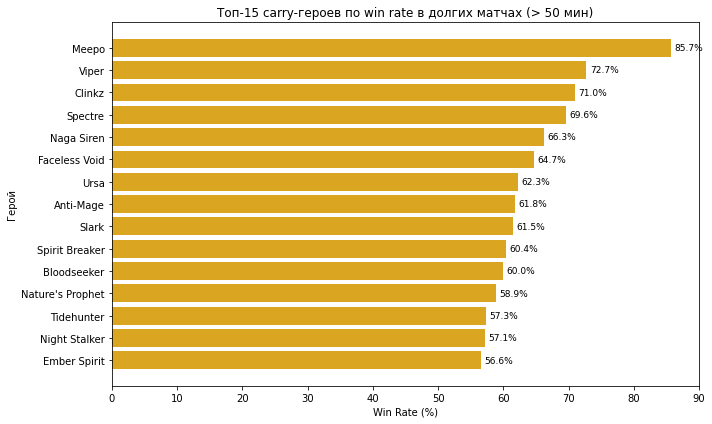

In [125]:
top_carry = carry_stats.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_carry['localized_name'], top_carry['winrate'], color='goldenrod')
plt.gca().invert_yaxis()
plt.title('Топ-15 carry-героев по win rate в долгих матчах (> 50 мин)')
plt.xlabel('Win Rate (%)')
plt.ylabel('Герой')

# Подписи
for i, v in enumerate(top_carry['winrate']):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()


**📝ВЫВОД:** В долгих матчах побеждают герои, способные масштабироваться (Meepo, Spectre, Naga),
или контролировать карту и файты (Viper, Clinkz, Faceless Void).

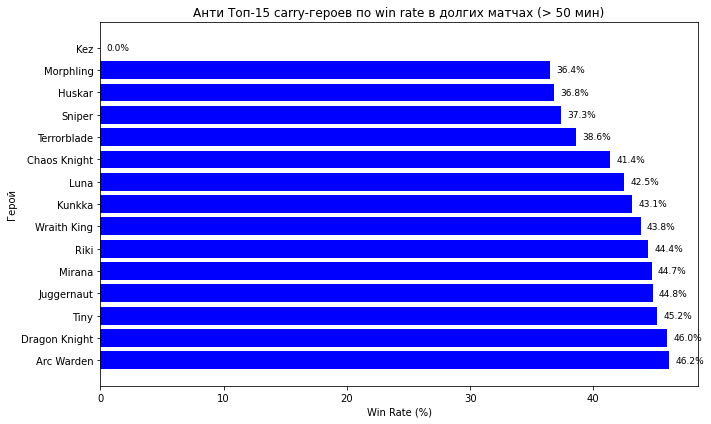

In [129]:
bottom_carry = carry_stats.tail(15)

plt.figure(figsize=(10, 6))
plt.barh(bottom_carry['localized_name'], bottom_carry['winrate'], color='blue')

plt.title('Анти Топ-15 carry-героев по win rate в долгих матчах (> 50 мин)')
plt.xlabel('Win Rate (%)')
plt.ylabel('Герой')

# Подписи
for i, v in enumerate(bottom_carry['winrate']):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

**📝ВЫВОД:** Герои с высоким winrate в долгих матчах — это, как правило персонажи, которые становятся сильнее к концу игры:

Герои с низким winrate после 50 минут — это ранние керри, которые теряют силу в лейте

## Общие выводы анализа игровых данных Dota 2

### 🏆1. Победы
   Наибольшее влияние на победу оказывает **количество ассистов** в матче.
    Далее следуют:
- количество опыта в минуту
- нанесенный урон
- заработанное золото
- количество убийств

**Влияние числовых показателей на вероятность победы в матече:**

1. Количество убийств (kills) больше у победивших команд
2. Количество смертей у победивших команд меньше
3. Средний и медианный уровень фарма примерно одинаковый, но вариация выше у победителей — они чаще “уходят в лейт” с доминированием по фарму
4. hero_damage выше у победителей, они наносят больше урона противнику
5. У большинства команд лечение минимальное (многие герои не обладают лечащими способностями)
6. Победители добивают **на 100–200 крипов больше**, чем проигравшие. Однако пики совпадают → решает **эффективность**, а не количество фарма.
7. Если команда наносит высокий удар по строениям (Tower Damage per Minute) , то она сбольшой вероятностью побеждает. Урон по башням — один из самых сильных предикторов победы.
8. GPM у победителей выше в большинстве случаев.

**Побед Света примерно на 5% больше, чем побед Тьмы**

---

### 💎 2. Предметы (Items)
Только у победителей встречается Iron Branch, только у проигравших Force Staff, использование каких-либо предметов не увеличивает вероятность победы.

---

### ⚔️ 3. Герои 
- Высокий GPM героя не гарантирует высокий winrate.  
- **Broodmother, Chen, Treant, Enigma** — выигрывают за счёт влияния, а не фарма.
- Разброс XP/min у топ-20 героев невелик (~750–850).
- Популярные герои (Rubick, Tiny, Jakiro) ≠ самые результативные.  
- Самый высокий winrate — у **редких, сложных героев** (Broodmother, Chen).  
> Популярность не коррелирует с эффективностью.
- Лидеры по количеству убийств: **Clinkz, Spectre, Ursa, Queen of Pain**.  
> Побеждают герои, которые задают **агрессивный темп игры**.
- Лидеры по количеству ассистов: **Disruptor, Io, Bounty Hunter, Spirit Breaker**.  
> Командная вовлечённость коррелирует с победой.
- Самые «живучие»: **Lycan, Medusa, Lifestealer, Templar Assassin**.  
> Устойчивость и мобильность повышают шанс на победу.

**Топ-игроки**

  - +43% убийств  
  - −36% смертей  
  - +48% ассистов  
- Разница по GPM и XPM ≈ +15–17%.  
> Решают **меньше ошибок и выше вовлечённость**.

---

### 🩸 4. Первая кровь и длительность матчей
- Медиана — **1.8 мин**, среднее — **2.2 мин**.  
> Большинство матчей начинаются с **ранней агрессии**,  
> но часть игр — с медленным темпом и “лейт”-ориентацией.

- Средняя длительность матча: 33.5 минут
- Медианная длительность матча: 31.6 минут

---

### 🕒 5. Долгие матчи (>50 мин)
- Лидеры: **Meepo, Viper, Clinkz, Spectre, Naga Siren**.  
> В лейте побеждают герои, которые **масштабируются**,  
> умеют **контролировать карту** и **выживать** в долгих боях.

---

### 📈6. Рейтинг игроков в команде
- Команды, в которых у игроков выше личный средний процент побед, существенно чаще выигрывают матчи.




## 3 Загрузка данных в supabase

In [130]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [131]:
import os
import pandas as pd
from sqlalchemy import create_engine, text


# === Параметры подключения  ===
USER='USER'
PASSWORD='Password'
HOST='aws-1-eu-central-1.pooler.supabase.com'
PORT='6543'
DBNAME='postgres'


# === Папка, где лежат CSV ===
DATA_DIR = r"C:\Users\workp\code\DOTA\CSV"

# === Таблицы для загрузки ===
csv_files = {
    "matches": "matches.csv",
    "players": "players.csv",
    "heroes": "heroes.csv",
    "items_dict": "items_dict.csv"
}

# === Настройка подключения ===
connection_string = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require'
engine = create_engine(connection_string)

# === Проверяем соединение ===
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT version();"))
        print("Подключение к базе успешно!")
        print("Версия сервера:", result.fetchone()[0])
except Exception as e:
    print("Ошибка подключения:", e)
    raise

# === Функция загрузки CSV ===
def upload_csv_to_db(table_name, file_path):
    print(f"\n--- Загружаем таблицу '{table_name}' ---")
    try:
        df = pd.read_csv(file_path)
        print(f"Прочитано {len(df)} строк и {len(df.columns)} столбцов из {os.path.basename(file_path)}")

        # Загружаем в базу (при необходимости можно заменить 'replace' на 'append')
        df.to_sql(table_name, engine, if_exists='replace', index=False)
        print(f"Таблица '{table_name}' успешно загружена в Supabase")

    except Exception as e:
        print(f"Ошибка при загрузке таблицы '{table_name}': {e}")

# === Основной цикл ===
for table_name, filename in csv_files.items():
    file_path = os.path.join(DATA_DIR, filename)
    if os.path.exists(file_path):
        upload_csv_to_db(table_name, file_path)
    else:
        print(f"Файл {filename} не найден, пропускаем")

print("\n🎉 Загрузка всех CSV завершена!")

✅ Подключение к базе успешно!
Версия сервера: PostgreSQL 17.6 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit

--- Загружаем таблицу 'matches' ---
Прочитано 19912 строк и 9 столбцов из matches.csv
Таблица 'matches' успешно загружена в Supabase

--- Загружаем таблицу 'players' ---
Прочитано 199120 строк и 31 столбцов из players.csv
Таблица 'players' успешно загружена в Supabase

--- Загружаем таблицу 'heroes' ---
Прочитано 126 строк и 11 столбцов из heroes.csv
Таблица 'heroes' успешно загружена в Supabase

--- Загружаем таблицу 'items_dict' ---
Прочитано 510 строк и 25 столбцов из items_dict.csv
Таблица 'items_dict' успешно загружена в Supabase

🎉 Загрузка всех CSV завершена!
